# Team Info

- Members:
  - Antoniadis Panagiotis - 03115009
  - Masouris Athanasios - 03115189
  - Bazotis Nikolaos - 03115739

# Importing necessary libraries

In [0]:
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import arff
import time

# pandas
import pandas as pd
from pandas.api.types import is_numeric_dtype

# imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV


# Define parameters of figures
plt.rcParams['figure.figsize'] = 10 , 10
plt.rcParams['text.color'] = "white"
plt.rcParams['xtick.color'] = "white"
plt.rcParams['ytick.color'] = "white"

import warnings
warnings.filterwarnings("ignore")

import pickle

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Dataset Analysis

![UCI ML Logo](http://archive.ics.uci.edu/ml/assets/logo.gif "UCI Machine Learning Repository")

In this project we will use the [Polish companies bankruptcy data](http://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data) from the UCI Machine Learning Repository. It contains data about bankruptcy prediction of Polish companies. The data was collected from Emerging Markets Information Service (EMIS), which is a database containing information on emerging markets around the world. The bankrupt companies were analyzed in the period 2000-2012, while the still operating companies were evaluated from 2007 to 2013. It includes 5 cases where each demonstrate samples of bankrupty  and contains some instances that represents bankrupted companies and other firms that did not bankrupt in the forecasting period. 
- 1st Year --> Bankrupt after 5 years (7027 instances)
- 2st Year --> Bankrupt after 4 years (10173 instances)
- 3st Year --> Bankrupt after 3 years (10503 instances)
- 4st Year --> Bankrupt after 2 years (9792 instances)
- 5st Year --> Bankrupt after 1 years (5910  instances)

Usually, this dataset is analyzed as a 5-case binary classification problem, since the labels in each case semantically differ. However, in this notebook we will concatenate the above 5 cases in one and the problem will be converted in a simple binary classification problem.

## Loading the Data


In [0]:
#Uploading the data file
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 5year.arff to 5year.arff
Saving 4year.arff to 4year.arff
Saving 3year.arff to 3year.arff
Saving 2year.arff to 2year.arff
Saving 1year.arff to 1year.arff
User uploaded file "5year.arff" with length 2899490 bytes
User uploaded file "4year.arff" with length 4829865 bytes
User uploaded file "3year.arff" with length 5169674 bytes
User uploaded file "2year.arff" with length 4987459 bytes
User uploaded file "1year.arff" with length 3432892 bytes


In [0]:
# Read the 5 arff files and keep them
# in a list as dataframes.
dfs = []
for i in range(5):
  data_arff = arff.loadarff(str(i+1) + 'year.arff')
  dfs.append(pd.DataFrame(data_arff[0]))

# Concatenate the five dataframes in one
df = pd.concat(dfs)

In [0]:
# Split data in the features and the labels (last collumn).
X_df = df.iloc[:,:-1]
y_df = df.iloc[:, -1:].astype('int')

# Print first and second examples to check validity.
print(X_df[:2])
print(y_df[:2])

     Attr1    Attr2    Attr3   Attr4  ...  Attr61   Attr62  Attr63   Attr64
0  0.20055  0.37951  0.39641  2.0472  ...  5.1372   82.658  4.4158   7.4277
1  0.20912  0.49988  0.47225  1.9447  ...  3.2732  107.350  3.4000  60.9870

[2 rows x 64 columns]
   class
0      0
1      0


## Description of features

In [0]:
m, n = X_df.shape
print("Number of examples: %d" %m)
print("Number of features: %d" %n)

Number of examples: 43405
Number of features: 64


In [0]:
print("The features of the dataset are:")
print(list(X_df.columns))

The features of the dataset are:
['Attr1', 'Attr2', 'Attr3', 'Attr4', 'Attr5', 'Attr6', 'Attr7', 'Attr8', 'Attr9', 'Attr10', 'Attr11', 'Attr12', 'Attr13', 'Attr14', 'Attr15', 'Attr16', 'Attr17', 'Attr18', 'Attr19', 'Attr20', 'Attr21', 'Attr22', 'Attr23', 'Attr24', 'Attr25', 'Attr26', 'Attr27', 'Attr28', 'Attr29', 'Attr30', 'Attr31', 'Attr32', 'Attr33', 'Attr34', 'Attr35', 'Attr36', 'Attr37', 'Attr38', 'Attr39', 'Attr40', 'Attr41', 'Attr42', 'Attr43', 'Attr44', 'Attr45', 'Attr46', 'Attr47', 'Attr48', 'Attr49', 'Attr50', 'Attr51', 'Attr52', 'Attr53', 'Attr54', 'Attr55', 'Attr56', 'Attr57', 'Attr58', 'Attr59', 'Attr60', 'Attr61', 'Attr62', 'Attr63', 'Attr64']


This dataset has 43405 examples and each of them has 64 features, that correspond to a financial rates. As we can see, the name of these rates are not included in the arff files. They are avaialble [here](http://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data).

## Checking for non numeric features

Since each feature of the dataset corresponds to a financial rate, we assume that there are only numeric features. We will check it using the above function.

In [0]:
def isnumeric(df):
  # Define a dataframe with the non numeric values of df
  select = df.select_dtypes(exclude=np.number)
  # If the shape returns 0, it means there aren't any columns with non numeric values. So flag must be True, thus the negation.
  flag = not bool(df.select_dtypes(exclude=np.number).shape[1]) 
  # Returns a list with the column names that have non numeric values
  not_numerics = df.select_dtypes(exclude=np.number).columns.tolist()
  
  return flag , not_numerics

In [0]:
numeric , not_numerics = isnumeric(X_df)
if (numeric):
  print("All features have numeric values")
else:
  for key in not_numerics:
    print(key + " feature is not numeric")

All features have numeric values


## Dataset labels

In [0]:
# Number of labels
print("The are %d labels with values" %y_df.nunique())
print(y_df['class'].unique())

The are 2 labels with values
[0 1]


Class __0__ means that the company was not bankrupted and class __1__ means that the company was bankrupted.

## Checking for missing values

Before classification, we should remove or substitute missing values, since our classifiers work with numeric values.

In [0]:
def missing_val(df):
  # Cheking for every example if there is a column with a missing value
  df_nulls = df.isnull().any(axis=1)
  # Checking if there is an example with a missing value
  flag = df_nulls.any()
  # Returns an array of indexes for the examples with a missing value
  null_examples = np.where(df_nulls == True)[0]

  return flag , null_examples

In [0]:
missing , examples =  missing_val(X_df)
if missing:
  print("There are %d examples with missing values," %examples.size)
  print("So %f percent of total examples contain missing values." %(examples.size/m *100))
  print("The examples that have missing values are the following:")
  print(examples)
else:
  print("There are no missing values")

There are 23438 examples with missing values,
So 53.998387 percent of total examples contain missing values.
The examples that have missing values are the following:
[    1     2     3 ... 43402 43403 43404]


We can either drop the examples that contain the missing values or substitute the missing value with the mean value of the feature. Since half of our examples contain missing values, we will substitute the missing values using an Imputer (otherwise we will lose half of the dataset).

In [0]:
imp_mean = Imputer(missing_values='NaN', strategy='mean', axis=0)

## Checking for balanced data

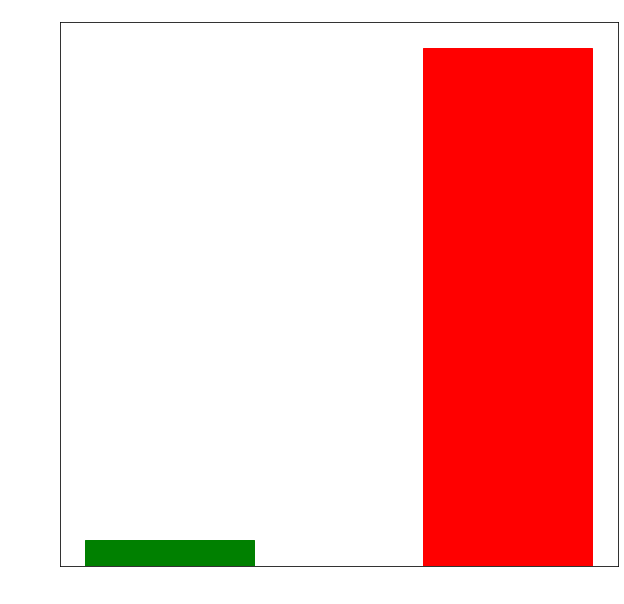

There are 2091 bankrupt examples and 41314 not bankrupt exmaples,
So 4.817417 percent of the examples are bankrupt and 95.182583 percent are not bankrupt.


In [0]:
n_bank = (y_df['class']==1).sum()
n_unbank = (y_df['class']==0).sum()

y = [n_bank, n_unbank]
x = ['Bankrupt', 'Not Bankrupt']


bars = plt.bar(x,y, width=0.5)
bars[0].set_color('g')
bars[1].set_color('r')
plt.title("Features Distribution")
plt.ylabel("Number of examples" , color='w')
plt.xlabel("Labels", color='w')
plt.show()


print("There are %d bankrupt examples and %d not bankrupt exmaples," %(n_bank, n_unbank))
print("So %f percent of the examples are bankrupt and %f percent are not bankrupt." %(n_bank/m*100, n_unbank/m*100))

We observe that our dataset is imbalanced, since (as expected) the number of companies that did not bankrupt is by far greater than the number of the bankrupted companies. We can resolve this situtation by using oversampling or undersampling.

## Train/Test split

In [0]:
# Split our data (30% of the dataset will be the test set)
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.30)

## Part B questions

1. **Write a short dataset description** \
See [Dataset Presentation](#scrollTo=3I_OX9hChwQV)
2. **Find the number of examples and features. Search if there are non numeric features and which are those.** \
See [Description of features](#scrollTo=Qwtv91JSqd6g) and [Checking for non numeric features](#scrollTo=HIaWoaPH9E9f).
3. **Check if there are any headers and line numbering.** \
None of the rows of the data files contains the names of corresponding features. There is not a line numbering.
4. **Which are the labels for the corresponding classes?** \
The labels for the classes in the files were on the last column on the same data file and as we can see [here](#scrollTo=upEEa4S59E5Y) they are '0'(no bankrupty) and '1'(bankrupty).
5. **Did you have to modify the text files?** \
No, we just load the filed in arff format.
6. **Are there any missing values in the dataset? On which examples? What is the percentage of the examples with a missing value?** \
As we can see at [Checking for missing values](#scrollTo=KAwwusxu9En9) there are many missing values in the dataset. More specifically, 54% of the examples have missing values. This means that we should not just drop all these rows, but use an Imputer.
7. **Find how many classes there are and check the balance of the dataset by calculating the percentage of examples each class has.** \
As we can see [here](#scrollTo=Y3KkTygW9pet) there are two classes. '0' " for No bankrupty instances and '1' for bankrupty. The dataset is not balanced, since, as expected, we have more non-bankruptcy cases. We will resolve this using oversampling or undersampling.
8. **Split the dataset to train/test sets and explain how you chose to handle the missing values and the non numeric values.** \
In the section [Train/Test split](#scrollTo=_g0gnm_oqHnN) we use the function sklearn.model_selection.train_test_split in order to split randomly our dataset to train and test subsets. We use the parameter test_size=0.30 in order to declare that we want the test set to be 30% of the whole dataset. In order to handle to missing values, we will use an imputer that has been defined above. It will replace all missing values with the mean value of the corresponding feature. All features are numerics, so we don't have to handle non numeric cases.

## Metrics

Before proceeding in the classification part, let's discuss first the metrics that will be used. Through our analysis, we should take into consideration that our dataset is very unbalanced. That's why we will not use accuracy but other metrics such as F1-score, precision and recall.

- confusion matrix: A 2*2 matrix where 𝐶𝑖,𝑗 equals the number of samples that belong to i class and are classified in j class.
- f1-micro average: F1-score that weights each sample equally.
- f1-macro average: F1-score that weights each class equally.

This means that, in case we just want to maximize our correct predictions, we use micro-averaged metrics. However, in our case, we value our minority class the most. In other words, it is more important for our classifier to correctly predict future bankrupts than just predict that a company will not bankrupt. That's why the macro-averaged metrics are more important.


# Baseline classification

In this part, we will evaluate some classifiers without searching for the best hyperparameters or preprocessing our dataset (this is done in the later section). We will just select some random hyperparameters.

First, we will use the Imputer in order to fill the missing values of our dataset, because our classifiers can't handle missing values. Also, we convert our dataframes in NumPy arrays.

In [0]:
imp_mean.fit(X_train_df)
X_train = imp_mean.transform(X_train_df)
X_test = imp_mean.transform(X_test_df)
y_train = y_train_df.to_numpy()
y_test = y_test_df.to_numpy()

## Dummy classifiers

Here we are going to evaluate some of the common dummy classifiers in our dataset. We are going to use the module DummyClassifier provided by sklearn. We will try the following strategies: \
- Uniform (random)
- Constant (1 or 2, for our classes)
- Most frequent
- Stratified

### Training and Accuracy

We will train our Dummy Classifiers in the train set.

In [0]:
dc_uniform = DummyClassifier(strategy="uniform")
dc_constant_0 = DummyClassifier(strategy="constant", constant=0)
dc_constant_1 = DummyClassifier(strategy="constant", constant=1)
dc_most_frequent = DummyClassifier(strategy="most_frequent")
dc_stratified = DummyClassifier(strategy="stratified")

# The fit method from sklearn trains the model in the training set.
dc_uniform.fit(X_train, y_train)
dc_constant_0.fit(X_train, y_train)
dc_constant_1.fit(X_train, y_train)
dc_most_frequent.fit(X_train, y_train)
dc_stratified.fit(X_train, y_train)

# Using the predict method we can then make predictions on the test set

# Uniform predictions
preds_uniform = dc_uniform.predict(X_test)

# Constant 1
preds_constant_0 = dc_constant_0.predict(X_test)

# Constant 2
preds_constant_1 = dc_constant_1.predict(X_test)

# Most frequent predictions
preds_most_frequent = dc_most_frequent.predict(X_test)

# Stratified predictions
preds_stratified = dc_stratified.predict(X_test)

Now based on the models we trained, we are going to calculate the accuracy of each strategy in our test set.

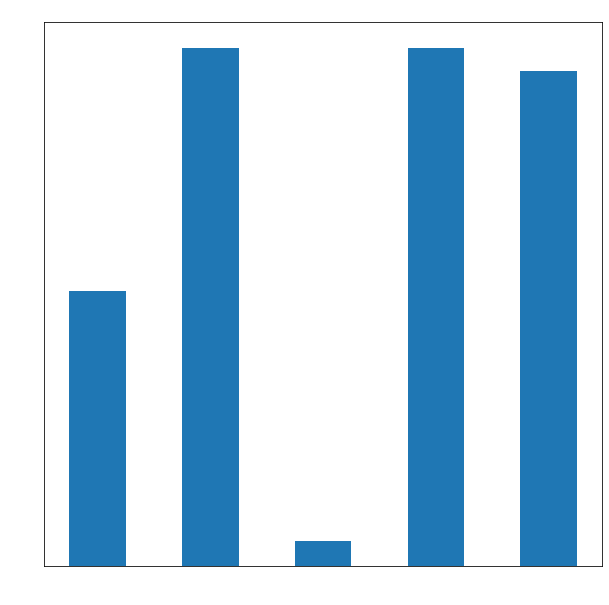

Classification Accuracy on the Polish companies bankruptcy Data Set (30% test set)

constant_0 0.9549992320688067
most frequent label 0.9549992320688067
stratified 0.9132237751497466
uniform 0.5063738289049301
constant_1 0.04500076793119336


In [0]:
# Create a dictionary with the accuracies of the dummy strategies
dummies_accuracy = {}
dummies_accuracy['uniform'] = dc_uniform.score(X_test, y_test)
dummies_accuracy['constant_0'] = dc_constant_0.score(X_test, y_test)
dummies_accuracy['constant_1'] = dc_constant_1.score(X_test, y_test)
dummies_accuracy['most frequent label'] = dc_most_frequent.score(X_test, y_test)
dummies_accuracy['stratified'] = dc_stratified.score(X_test, y_test)

# Create a barplot for the accuracies
x = [key for key in dummies_accuracy.keys()]
y = [value for value in dummies_accuracy.values()]
bars = plt.bar(x,y, width=0.5)
plt.title("Accuracy with dummy classifiers")
plt.ylabel("Accuracy" , color='w')
plt.xlabel("Strategy", color='w')
plt.show()

# Print the sorted results
print("Classification Accuracy on the Polish companies bankruptcy Data Set (30% test set)\n")
sorted_accuracy = [(k, dummies_accuracy[k]) for k in sorted(dummies_accuracy, key=dummies_accuracy.get, reverse=True)]
for k, v in sorted_accuracy:
  print(k,v)


### Confusion matrices, f1_micro and f1_macro scores 

In [0]:
UNDERLINE = '\033[4m'
END = '\033[0m'

# Calculate the confusion matrices of the above strategies
dummies_cm = {}
dummies_cm['uniform'] = confusion_matrix(y_test, preds_uniform)
dummies_cm['constant_0'] = confusion_matrix(y_test, preds_constant_0)
dummies_cm['constant_1'] = confusion_matrix(y_test, preds_constant_1)
dummies_cm['most frequent label'] = confusion_matrix(y_test, preds_most_frequent)
dummies_cm['stratified'] = confusion_matrix(y_test, preds_stratified)

# Calculate the f1 micro average score of the above strategies
dummies_f1_micro = {}
dummies_f1_micro['uniform'] = f1_score(y_test, preds_uniform, average="micro")
dummies_f1_micro['constant_0'] = f1_score(y_test, preds_constant_0, average="micro")
dummies_f1_micro['constant_1'] = f1_score(y_test, preds_constant_1, average="micro")
dummies_f1_micro['most frequent label'] = f1_score(y_test, preds_most_frequent, average="micro")
dummies_f1_micro['stratified'] = f1_score(y_test, preds_stratified, average="micro")

# Calculate the f1 macro average score of the above strategies
dummies_f1_macro = {}
dummies_f1_macro['uniform'] = f1_score(y_test, preds_uniform, average="macro")
dummies_f1_macro['constant_0'] = f1_score(y_test, preds_constant_0, average="macro")
dummies_f1_macro['constant_1'] = f1_score(y_test, preds_constant_1, average="macro")
dummies_f1_macro['most frequent label'] = f1_score(y_test, preds_most_frequent, average="macro")
dummies_f1_macro['stratified'] = f1_score(y_test, preds_stratified, average="macro")



print("Confusion matrix for the " + UNDERLINE + "uniform strategy" + END +":")
print(dummies_cm['uniform'])
print("f1-micro average: %f" %dummies_f1_micro['uniform'])
print("f1-macro average: %f" %dummies_f1_macro['uniform'])

print("\nConfusion matrix for the " + UNDERLINE + "constant 0 strategy" + END +":")
print(dummies_cm['constant_0'])
print("f1-micro average: %f" %dummies_f1_micro['constant_0'])
print("f1-macro average: %f" %dummies_f1_macro['constant_0'])

print("\nConfusion matrix for the " + UNDERLINE + "constant 1 strategy" + END +":")
print(dummies_cm['constant_1'])
print("f1-micro average: %f" %dummies_f1_micro['constant_1'])
print("f1-macro average: %f" %dummies_f1_macro['constant_1'])

print("\nConfusion matrix for the " + UNDERLINE + "most frequent strategy" + END +":")
print(dummies_cm['most frequent label'])
print("f1-micro average: %f" %dummies_f1_micro['most frequent label'])
print("f1-macro average: %f" %dummies_f1_macro['most frequent label'])

print("\nConfusion matrix for the " + UNDERLINE + "stratified strategy" + END +":")
print(dummies_cm['stratified'])
print("f1-micro average: %f" %dummies_f1_micro['stratified'])
print("f1-macro average: %f" %dummies_f1_macro['stratified'])

Confusion matrix for the uniform strategy:
[[6239 6197]
 [ 274  312]]
f1-micro average: 0.503072
f1-macro average: 0.373227

Confusion matrix for the constant 0 strategy:
[[12436     0]
 [  586     0]]
f1-micro average: 0.954999
f1-macro average: 0.488491

Confusion matrix for the constant 1 strategy:
[[    0 12436]
 [    0   586]]
f1-micro average: 0.045001
f1-macro average: 0.043063

Confusion matrix for the most frequent strategy:
[[12436     0]
 [  586     0]]
f1-micro average: 0.954999
f1-macro average: 0.488491

Confusion matrix for the stratified strategy:
[[11825   611]
 [  558    28]]
f1-micro average: 0.910229
f1-macro average: 0.499307


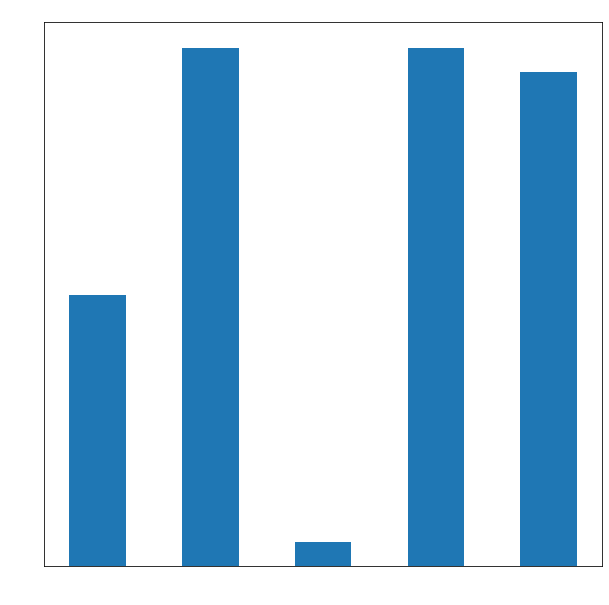

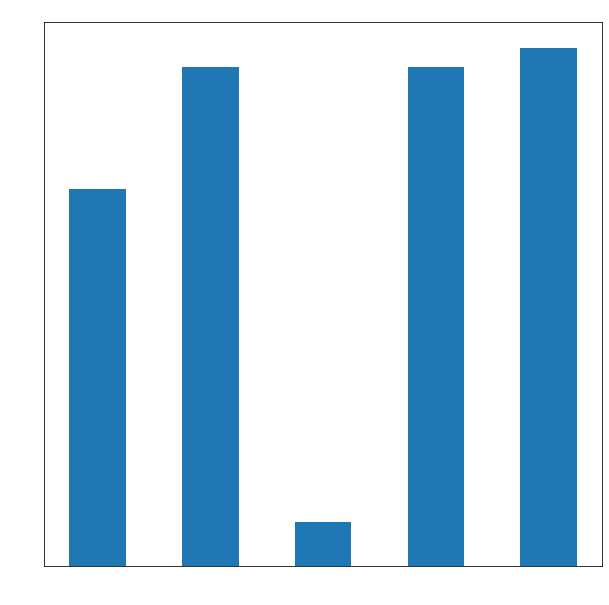

In [0]:
# Create a barplot for the F1 micro averages
x_micro = [key for key in dummies_f1_micro.keys()]
y_micro = [value for value in dummies_f1_micro.values()]
bars = plt.bar(x_micro,y_micro, width=0.5)
plt.title("f1 micro score with dummy classifiers")
plt.ylabel("f1 micro score" , color='w')
plt.xlabel("Strategy", color='w')
plt.show()

# Create a barplot for the F1 macro averages
x_macro = [key for key in dummies_f1_macro.keys()]
y_macro = [value for value in dummies_f1_macro.values()]
bars = plt.bar(x_macro,y_macro, width=0.5)
plt.title("f1 macro score with dummy classifiers")
plt.ylabel("f1 macro score" , color='w')
plt.xlabel("Strategy", color='w')
plt.show()

### Classification reports

In [0]:
print("Classification Precision, Recall, F1 on the Polish companies bankruptcy Data Set (30% test set)")

print("\n"+UNDERLINE+"Uniform strategy"+END+"\n")
print(classification_report(y_test, preds_uniform))
print("\n"+UNDERLINE+"Constant 0 strategy"+END+"\n")
print(classification_report(y_test, preds_constant_0))
print("\n"+UNDERLINE+"Constant 1 strategy"+END+"\n")
print(classification_report(y_test, preds_constant_1))
print("\n"+UNDERLINE+"Most frequent strategy"+END+"\n")
print(classification_report(y_test, preds_most_frequent))
print("\n"+UNDERLINE+"Stratified strategy"+END+"\n")
print(classification_report(y_test, preds_stratified))

Classification Precision, Recall, F1 on the Polish companies bankruptcy Data Set (30% test set)

Uniform strategy

              precision    recall  f1-score   support

           0       0.96      0.50      0.66     12440
           1       0.04      0.50      0.08       582

    accuracy                           0.50     13022
   macro avg       0.50      0.50      0.37     13022
weighted avg       0.91      0.50      0.63     13022


Constant 0 strategy

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     12440
           1       0.00      0.00      0.00       582

    accuracy                           0.96     13022
   macro avg       0.48      0.50      0.49     13022
weighted avg       0.91      0.96      0.93     13022


Constant 1 strategy

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12440
           1       0.04      1.00      0.09       582

    accuracy           

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Gaussian Naive Bayes classifier


In this section we are going to use the Gaussian Naive Bayes classifier from sklearn. \

### Training and Accuracy

In [0]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
preds_gnb = gnb.predict(X_test)
print("The accuracy score for the Gaussian Naive Bayes algorithm is: %f" %accuracy_score(y_test, preds_gnb))

The accuracy score for the Gaussian Naive Bayes algorithm is: 0.071725


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Confusion matrix, f1_micro and f1_macro scores

In [0]:
gnb_cm = confusion_matrix(y_test, preds_gnb)
print(gnb_cm)

[[  368 12072]
 [   16   566]]


In [0]:
gau_nb_f1_micro = f1_score(y_test, preds_gnb, average="micro")
gau_nb_f1_macro = f1_score(y_test, preds_gnb, average="macro")

print("f1-micro average: %f" %gau_nb_f1_micro)
print("f1-macro average: %f" %gau_nb_f1_macro)

f1-micro average: 0.071725
f1-macro average: 0.071510


### Classification report

In [0]:
print("\nClassification Precision, Recall, F1 on the Polish companies bankruptcy Data Set (30% test set)")
print(classification_report(y_test, preds_gnb))


Classification Precision, Recall, F1 on the Polish companies bankruptcy Data Set (30% test set)
              precision    recall  f1-score   support

           0       0.96      0.03      0.06     12440
           1       0.04      0.97      0.09       582

    accuracy                           0.07     13022
   macro avg       0.50      0.50      0.07     13022
weighted avg       0.92      0.07      0.06     13022



### Cumulatively F1-scores plots

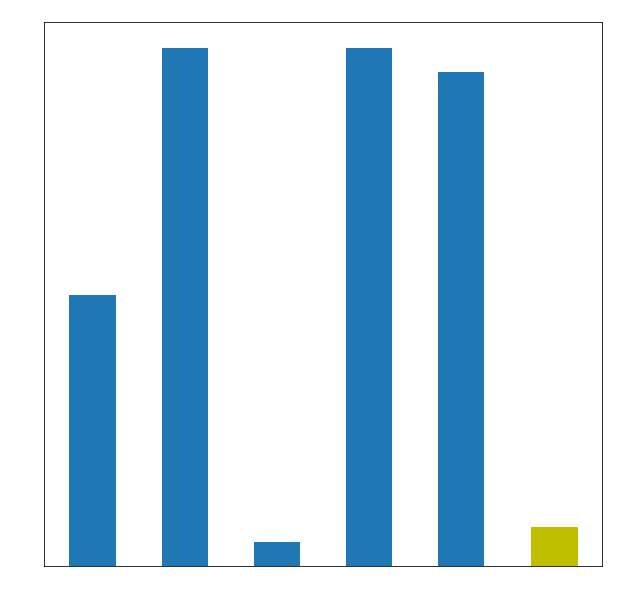

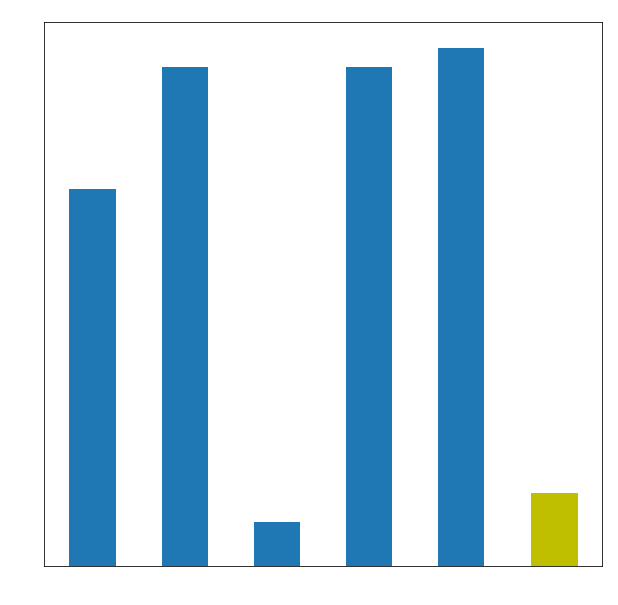

In [0]:
# Create a barplot for the F1 micro averages
x_micro.append("Gaussian NB algorithm")
y_micro.append(gau_nb_f1_micro)
bars = plt.bar(x_micro,y_micro, width=0.5)
bars[5].set_color('y')
plt.title("f1 micro score on different classifiers")
plt.ylabel("f1 micro score" , color='w')
plt.xlabel("Strategy", color='w')
plt.show()

# Create a barplot for the F1 macro averages
x_macro.append("Gaussian NB algorithm")
y_macro.append(gau_nb_f1_macro)
bars = plt.bar(x_macro,y_macro, width=0.5)
bars[5].set_color('y')
plt.title("f1 macro score on different classifiers")
plt.ylabel("f1 macro score" , color='w')
plt.xlabel("Strategy", color='w')
plt.show()

## kNN classifier

In this section we are going to use the k Nearest Neighbors Classifier. \

The kNN algorithm is a non-parametric classification method. A point is classified to the class most common among its k nearest neighbors. \
\
The value of k is usually a small integer. \
\
For this section the value of k will be 5 (k=5). We are going to search for the optimal value of k in a later section. 

In [0]:
# Chosen value of k is 5
k=5

knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(X_train, y_train)
preds_knn = knn.predict(X_test)
print("The accuracy score for kNN algorithm with k=%d is: %f" %(k,accuracy_score(y_test, preds_knn)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


The accuracy score for kNN algorithm with k=5 is: 0.952542


### Confusion matrix, f1_macro and f1_micro scores

In [0]:
knn_5_cm = confusion_matrix(y_test, preds_knn)
print(knn_5_cm)

[[12352    88]
 [  530    52]]


In [0]:
neigh_f1_micro = f1_score(y_test, preds_knn, average="micro")
neigh_f1_macro = f1_score(y_test, preds_knn, average="macro")

print("f1-micro average: %f" %neigh_f1_micro)
print("f1-macro average: %f" %neigh_f1_macro)

f1-micro average: 0.952542
f1-macro average: 0.559819


### Classification report

In [0]:
print("Classification Precision, Recall, F1 on the Polish companies bankruptcy Data Set (30% test set)")
print(classification_report(y_test, preds_knn))

Classification Precision, Recall, F1 on the Polish companies bankruptcy Data Set (30% test set)
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     12440
           1       0.37      0.09      0.14       582

    accuracy                           0.95     13022
   macro avg       0.67      0.54      0.56     13022
weighted avg       0.93      0.95      0.94     13022



### Cumulatively F1-scores plots

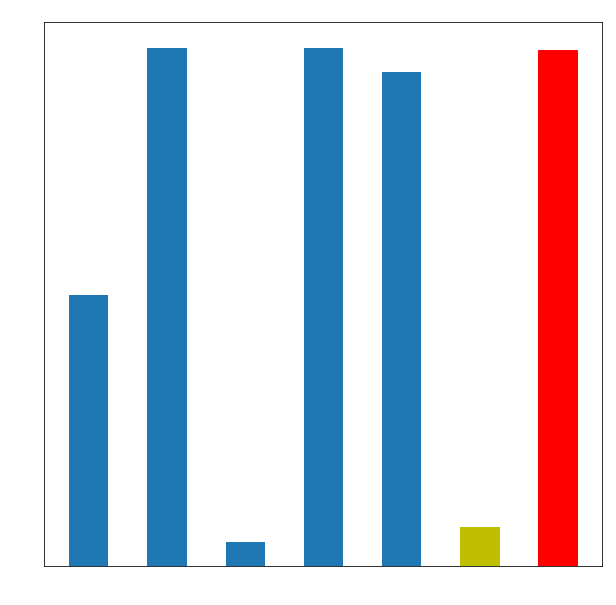

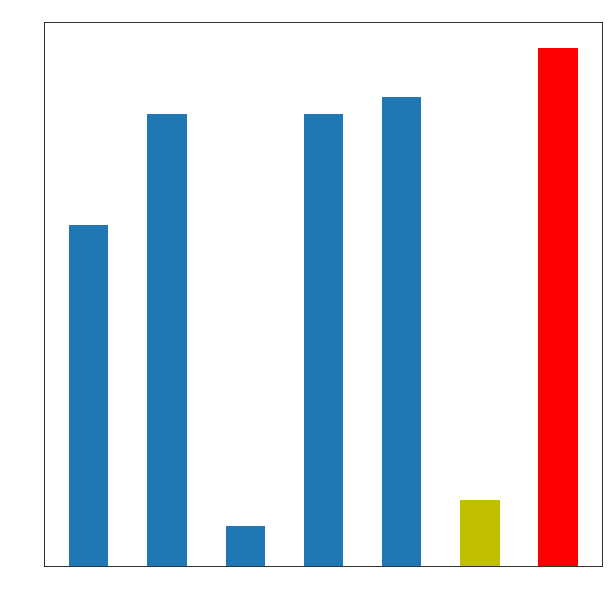

In [0]:
#Creating a barplot for the F1 micro averages
x_micro.append("kNN algorithm (k=5)")
y_micro.append(neigh_f1_micro)
bars = plt.bar(x_micro,y_micro, width=0.5)
bars[5].set_color('y')
bars[6].set_color('red')
plt.title("f1 micro score on different classifiers")
plt.ylabel("f1 micro score" , color='w')
plt.xlabel("Strategy", color='w')
plt.show()

#Creating a barplot for the F1 micro averages
x_macro.append("kNN algorithm (k=5)")
y_macro.append(neigh_f1_macro)
bars = plt.bar(x_macro,y_macro, width=0.5)
bars[5].set_color('y')
bars[6].set_color('red')
plt.title("f1 macro score on different classifiers")
plt.ylabel("f1 macro score" , color='w')
plt.xlabel("Strategy", color='w')
plt.show()

The k-nn algorithm has the same f1-micro average as our dummy classifiers. However, it achieves higher f1-macro average that is our global score since our dataset is not balanced.

## Multi-Layer Perceptron

In this section we are going to evaluate a Multi-Layer Perceptron using some random hyperparameters.

### Training and Accuracy

In [0]:

mlp =  MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(5, 2))

mlp.fit(X_train, y_train)
preds_mlp = mlp.predict(X_test)
print("The accuracy score for MLP algorithm  is: %f" %accuracy_score(y_test, preds_mlp))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The accuracy score for MLP algorithm  is: 0.955306


### Confusion matrix, f1_macro and f1_micro scores

In [0]:
mlp_cm = confusion_matrix(y_test, preds_mlp)
print(mlp_cm)

[[12440     0]
 [  582     0]]


In [0]:
mlp_f1_micro = f1_score(y_test, preds_mlp, average="micro")
mlp_f1_macro = f1_score(y_test, preds_mlp, average="macro")

print("f1-micro average: %f" %mlp_f1_micro)
print("f1-macro average: %f" %mlp_f1_macro)

f1-micro average: 0.955306
f1-macro average: 0.488571


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Classification report

In [0]:
print("\nClassification Precision, Recall, F1 on the Polish companies bankruptcy Data Set (30% test set)")
print(classification_report(y_test, preds_mlp))


Classification Precision, Recall, F1 on the Polish companies bankruptcy Data Set (30% test set)
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     12440
           1       0.00      0.00      0.00       582

    accuracy                           0.96     13022
   macro avg       0.48      0.50      0.49     13022
weighted avg       0.91      0.96      0.93     13022



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Cumulatively F1-scores plots

['uniform', 'constant_0', 'constant_1', 'most frequent label', 'stratified', 'Gaussian NB algorithm', 'kNN algorithm (k=5)', 'MLP algorithm']


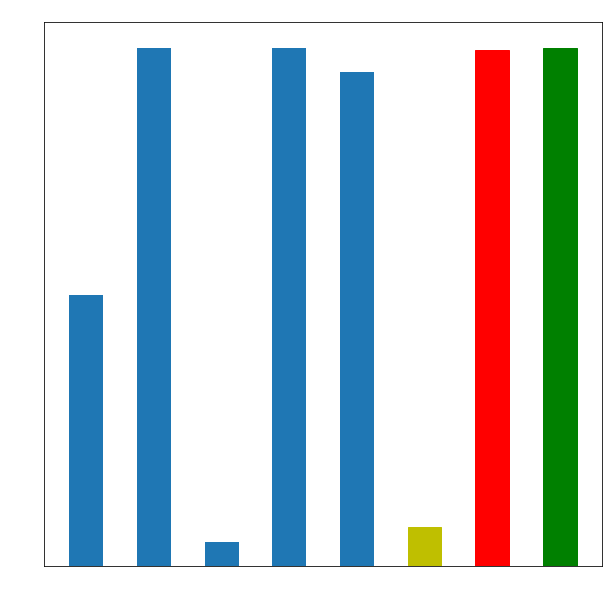

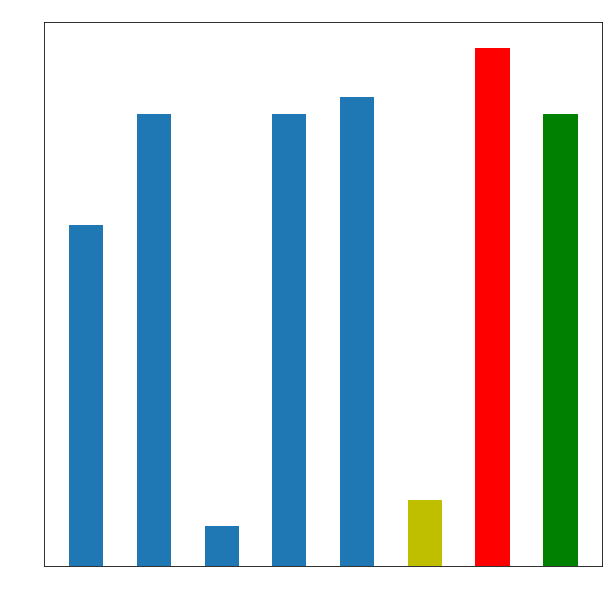

In [0]:
#Creating a barplot for the F1 micro averages
x_micro.append("MLP algorithm")
y_micro.append(mlp_f1_micro)
bars = plt.bar(x_micro,y_micro, width=0.5)
print(x_micro)
bars[5].set_color('y')
bars[6].set_color('red')
bars[7].set_color('green')
plt.title("f1 micro score on different classifiers")
plt.ylabel("f1 micro score" , color='w')
plt.xlabel("Strategy", color='w')
plt.show()

#Creating a barplot for the F1 micro averages
x_macro.append("MLP algorithm")
y_macro.append(mlp_f1_macro)
bars = plt.bar(x_macro,y_macro, width=0.5)
bars[5].set_color('y')
bars[6].set_color('red')
bars[7].set_color('green')
plt.title("f1 macro score on different classifiers")
plt.ylabel("f1 macro score" , color='w')
plt.xlabel("Strategy", color='w')
plt.show()

The MLP algorithm doesn't perform well in the f1-macro average.

## Project questions

1. See the [Dummy classifiers](#scrollTo=wMdRUsfInwOJ), [Gaussian Naive Bayes classifier](#scrollTo=2yO1QWZNn3ew), [kNN classifier](#scrollTo=lMDT4wgyn4Yj) and [MLP classifier](#scrollTo=dckO7fJ6_svq) subsections.
2. See [Cumulatively F1-scores plots](#scrollTo=vQdHTsnoNAff)
3. First of all, it is important to remember the scope of our classication.

  The Polish companies bankruptcy dataset is about predicting if a company will bankrupt or not. So it's clear that it is more important to don't give false predictions when a company will bankrupt than when a comapny will not bankrupt. In the first case, we will not notify them that they need to change something in order to avoid bankruptcy, while in the other case we concern them wihout a reason. Also, since our dataset is unbalanced, we care more about the f1-macro metric, while f1-micro and accuracy are high wihtout a good classifier (using just a simple constant-0 classifier).

  We observe that the constant_0, the most frequent and the stratified classifiers have the best accuracy, since the class 0 is the 95% of the dataset. The uniform classifiers predicts half of the train examples correctly, while the constant_1 is very poor, since the class 1 is very rare.

  As for the Gaussian Naive Bayes classifier, it performs poorly in our dataset. More specifically, it has a large amount of false positives, that means it predicts a lot of time that a company will bankrupt, while it will not. This might happens due the fact that a Gaussian Naive Bayes assumes that all the features are following a gaussian distribution.

  On the other hand, the k-NN classifier achieves the highest f1-macro metric, while keeping f1-micro and accuracy in a high value.

  Finally, the MLP classifier has the same behavior with the constant 0 classifier. Of course, this is a baseline classification with random hyperparameters and the MLP classifier can achive higher metrics with the proper hypeparameters.


# Classifiers optimization

In this section we are going to implement some optimization techniques such as dataset pre-processing and hyperparameter optimization.

## Data pre-processing

We are going to try the following pre-processing methods: \
- Dimensionality reduction:
  - Feature Selection (Variance threshold)
  - Feature Extraction (Principal Components Analysis - PCA)
- Normalization (z-score)
- Balancing the data (Oversampling/Undersampling)


### Feature selection - Variance Threshold

It should be noted that dimensionality reduction won't help the performance of the dummy classifiers (it won't cause any damage either) since they only rely on the distribution of the labels in our dataset. 
\
\
We will apply a feature selector that removes all the low-variance features. This method is called Variance Threshold. The default value of the threshold is zero, which means that the selector will remove all the features with constant values. We will try different thresholds later and compare the results.

In [0]:
selector = VarianceThreshold()

In order to select the range of the values of the threshold, we print the variance of each feature. 

In [0]:
train_variance = X_train.var(axis=0)
print(train_variance)

print('Max variance:')
print(np.max(train_variance))

[3.19718943e+00 2.78247589e+01 2.15244037e+01 1.21871916e+05
 4.97944594e+09 4.02177535e+01 3.52195166e+01 3.36879316e+05
 4.49849197e+03 1.81961002e+02 2.84765415e+01 2.36966839e+03
 9.60419536e+03 3.52195161e+01 1.17389889e+10 2.59883618e+03
 3.36936168e+05 3.54439028e+01 3.26971499e+03 2.00764650e+09
 3.86096711e+04 2.73308084e+01 3.23334078e+03 6.17694606e+01
 1.09915174e+02 2.22893546e+03 1.07932209e+09 2.33007394e+04
 6.84822374e-01 8.16760056e+05 3.27768088e+03 1.61314415e+09
 1.89396510e+04 1.86403350e+04 2.36396247e+01 4.49525759e+03
 6.64353159e+06 1.85306639e+02 2.12965580e+03 2.24953109e+03
 2.74570234e+06 2.96987621e+02 3.07748271e+10 1.71559771e+10
 5.82759522e+06 1.21829755e+05 3.38296888e+08 2.35173763e+01
 2.83531278e+03 1.32333255e+05 2.14785432e+01 2.48885440e+05
 1.71786166e+06 1.73605152e+06 4.78955073e+09 4.04298175e+07
 1.39475522e+02 4.05616033e+07 1.90111464e+04 1.25834675e+09
 4.68873957e+04 2.69851934e+10 2.05421360e+04 6.84846629e+06]
Max variance:
307748270

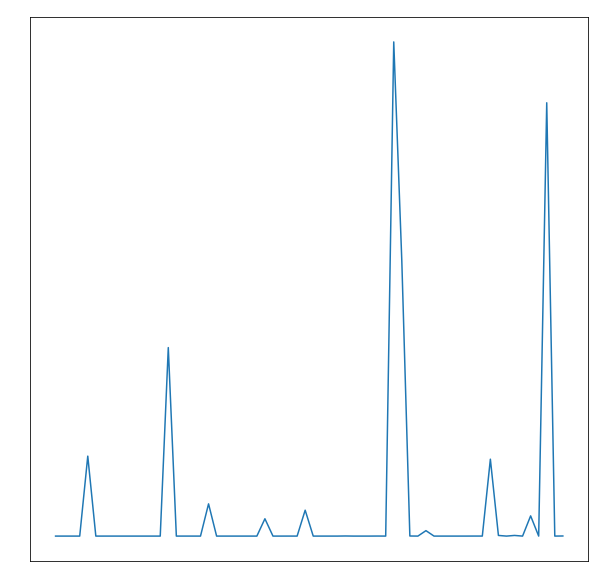

In [0]:
plt.plot(train_variance)

In [0]:
vthreshold = np.linspace(0, 10**7, 3)

In [0]:
vthreshold

array([       0.,  5000000., 10000000.])

### Feature Extraction - PCA

We are going to apply the Principal Components Analysis as a method for feature extraction in order to achieve dimensionality reduction. The number of components is a new hyperparameter. We will experiment with different values later.

In [0]:
pca = PCA()

In [0]:
n_components = [5, 7, 9]

### Normalization - z-score

Τhe normalization method is important for the k Nearest Neighbors (kNN) algorithm. \\

Lets say that we have the following features in our dataset:
- x<sub>1</sub> : with values in the range [0,1]
- x<sub>2</sub> : with values in the range [-100000,100000]

In order to find the k nearest neighbors, the kNN algorithm will calculate the distances. The most widely used distance metric for kNN is the Euclidean distance. So when taking the euclidean distance between pairs of examples, the values of the feature x<sub>1</sub> will probably become uninformative and the algorithm would rely only on the values of the x<sub>2</sub> feature. So normalization will help the kNN algorithm to take into consideration all the features. \\

For the same reason as described above scaling the data won't help the performance of the dummy classifiers.

In [0]:
scaler = StandardScaler()

### Balancing the data - Oversampling \ UnderSampling

Balancing the data is the last significant step of data pre-processing in the cross validation phase. \
\
This processing though will affect not only the performance of the kNN classifier, but the performance of the dummy classifiers too. 

In [0]:
ros = RandomOverSampler()

## Hyperparameter tuning

In order to optimize our hyperparameters, we are going to implement 5-fold cross validation with gridsearch.

The hyperparameters we have to tune are the following:
- Variance threshold for feature selection
- Number of components for PCA
- k, metric, weights for the kNN algorithm
- hidden_layer_sizes, activation, solver, max_iter, learning_rate, alpha for MLP

Define a function that trains and evaluates a GridSearch procedure.

In [0]:
def grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, score):
  pipe = Pipeline(steps , memory = 'tmp')
  estimator = GridSearchCV(pipe, grid_params, cv=5,scoring=score ,n_jobs=-1)
  start_time = time.time()
  estimator.fit(X_train, y_train)
  preds = estimator.predict(X_test)
  ttime =  time.time() - start_time
  return preds, ttime, estimator.best_estimator_


In [0]:
def compare_bars(x_opt, y_opt, x_base, y_base, title, y_label, x_ticks, name_ticks):
  
  bars = plt.bar(x_opt, y_opt, width=0.4, label="optimized")
  bars = plt.bar(x_base, y_base, width=0.4, label="baseline")
  plt.title(title)
  plt.ylabel(y_label , color='w')
  plt.xlabel("Strategy", color='w')
  plt.xticks(x_ticks, name_ticks)

  leg = plt.legend()
  for text in leg.get_texts():
      plt.setp(text, color = 'black')

  plt.show()


## Dummy Classifiers

As we explained in each subsection of the [Data pre-processing](#scrollTo=4KC8SeAFGY48), only the oversamping technique has an impact on the performance of the dummy classifiers since they rely only on the frequency of appearance of each label in the dataset. 

So lets see the performance on the oversampled data.

In [0]:
dc_uniform_opt = DummyClassifier(strategy="uniform")
dc_constant_0_opt = DummyClassifier(strategy="constant", constant=0)
dc_constant_1_opt = DummyClassifier(strategy="constant", constant=1)
dc_most_frequent_opt = DummyClassifier(strategy="most_frequent")
dc_stratified_opt = DummyClassifier(strategy="stratified")

Define a pipeline using only the ros as preprocessing.

In [0]:
grid_params = {}

steps=[('ros', ros), ('dc_uniform', dc_uniform_opt)]

preds_uniform_r, ttime_uniform_r, best_uniform_r = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_macro')

steps=[('ros', ros),  ('dc_costant_0', dc_constant_0_opt)]

preds_constant_0_r, ttime_constant_0_r, best_constant_0_r = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_macro')

steps=[('ros', ros),  ('dc_constant_1', dc_constant_1_opt)]

preds_constant_1_r, ttime_constant_1_r, best_constant_1_r = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_macro')

steps=[('ros', ros), ('dc_most_frequent', dc_most_frequent_opt)]

preds_most_frequent_r, ttime_most_frequent_r, best_most_frequent_r = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_macro')

steps=[('ros', ros),  ('dc_uniform', dc_uniform_opt)]

preds_stratified_r, ttime_stratified_r, best_stratified_r = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_macro')

Keep the evaluation metrics

In [0]:
dummies_f1_micro_opt = {}
dummies_f1_macro_opt = {}
dummies_best_estimator = {}
dummies_time = {}


dummies_f1_micro_opt['uniform'] = f1_score(y_test, preds_uniform_r, average="micro")
dummies_f1_macro_opt['uniform'] = f1_score(y_test, preds_uniform_r, average="macro")
dummies_best_estimator['uniform'] = best_uniform_r
dummies_time['uniform'] = ttime_uniform_r

dummies_f1_micro_opt['constant_0'] = f1_score(y_test, preds_constant_0_r, average="micro")
dummies_f1_macro_opt['constant_0'] = f1_score(y_test, preds_constant_0_r, average="macro")
dummies_best_estimator['constant_0'] = best_constant_0_r
dummies_time['constant_0'] = ttime_constant_0_r

dummies_f1_micro_opt['constant_1'] = f1_score(y_test, preds_constant_1_r, average="micro")
dummies_f1_macro_opt['constant_1'] = f1_score(y_test, preds_constant_1_r, average="macro")
dummies_best_estimator['constant_1'] = best_constant_1_r
dummies_time['constant_1'] = ttime_constant_1_r

dummies_f1_micro_opt['most_frequent'] = f1_score(y_test, preds_most_frequent_r, average="micro")
dummies_f1_macro_opt['most_frequent'] = f1_score(y_test, preds_most_frequent_r, average="macro")
dummies_best_estimator['most_frequent'] = best_most_frequent_r
dummies_time['most_frequent'] = ttime_most_frequent_r

dummies_f1_micro_opt['stratified'] = f1_score(y_test, preds_stratified_r, average="micro")
dummies_f1_macro_opt['stratified'] = f1_score(y_test, preds_stratified_r, average="macro")
dummies_best_estimator['stratified'] = best_stratified_r
dummies_time['stratified'] = ttime_stratified_r

print("Confusion matrix for the " + UNDERLINE + "uniform strategy" + END +":")
print("f1-micro average: %f" %dummies_f1_micro_opt['uniform'])
print("f1-macro average: %f" %dummies_f1_macro_opt['uniform'])

print("\nConfusion matrix for the " + UNDERLINE + "constant 0 strategy" + END +":")
print("f1-micro average: %f" %dummies_f1_micro_opt['constant_0'])
print("f1-macro average: %f" %dummies_f1_macro_opt['constant_0'])

print("\nConfusion matrix for the " + UNDERLINE + "constant 1 strategy" + END +":")
print("f1-micro average: %f" %dummies_f1_micro_opt['constant_1'])
print("f1-macro average: %f" %dummies_f1_macro_opt['constant_1'])

print("\nConfusion matrix for the " + UNDERLINE + "most frequent strategy" + END +":")
print("f1-micro average: %f" %dummies_f1_micro_opt['most_frequent'])
print("f1-macro average: %f" %dummies_f1_macro_opt['most_frequent'])

print("\nConfusion matrix for the " + UNDERLINE + "stratified strategy" + END +":")
print("f1-micro average: %f" %dummies_f1_micro_opt['stratified'])
print("f1-macro average: %f" %dummies_f1_macro_opt['stratified'])

Confusion matrix for the uniform strategy:
f1-micro average: 0.498848
f1-macro average: 0.372135

Confusion matrix for the constant 0 strategy:
f1-micro average: 0.954999
f1-macro average: 0.488491

Confusion matrix for the constant 1 strategy:
f1-micro average: 0.045001
f1-macro average: 0.043063

Confusion matrix for the most frequent strategy:
f1-micro average: 0.954999
f1-macro average: 0.488491

Confusion matrix for the stratified strategy:
f1-micro average: 0.500538
f1-macro average: 0.371303


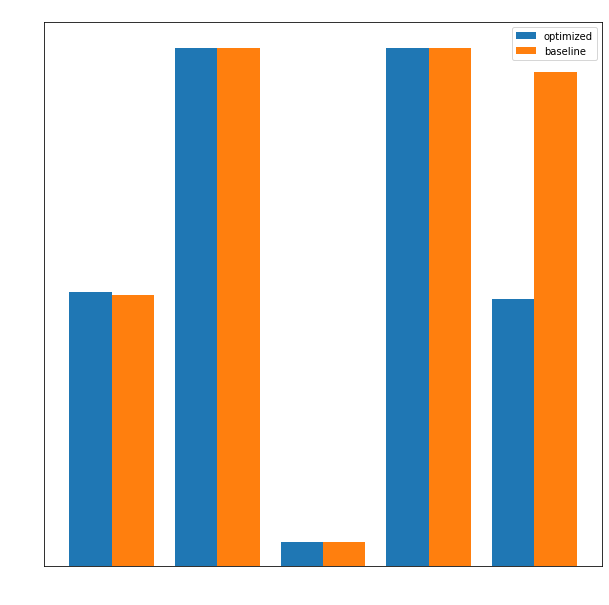

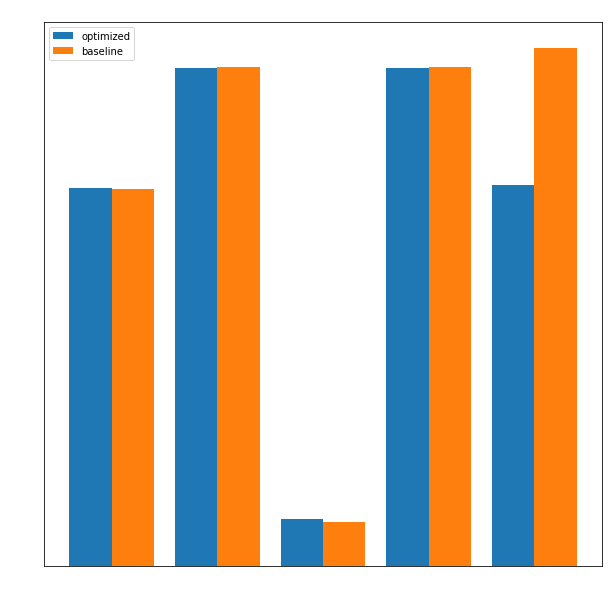

In [0]:
#Creating a barplot for the F1 micro averages
x_micro_opt = [key for key in dummies_f1_micro_opt.keys()]
y_micro_opt = [value for value in dummies_f1_micro_opt.values()]

x = np.arange(len(y_micro_opt))
x_shifted = [i + 0.4 for i in x]


compare_bars(x, y_micro_opt, x_shifted, y_micro[:5], "f1 micro score with dummy classifiers", "f1 micro score", \
             x, x_micro_opt)

compare_bars(x, y_macro_opt, x_shifted, y_macro[:5], "f1 macro score with dummy classifiers", "fa micro score", \
             x, x_micro_opt)


We observe thath the ovesampling did not improve the metrics in the dummy classifier. Especially, in the stratified classifier, the metrics are lower because the distribution became more balanced.

## Gaussian Naive Bayes classifier

Define a Gaussian classifier.

In [0]:
gnb = GaussianNB()

- Usa a selector only

In [0]:
steps=[('selector', selector),('gnb', gnb)]
grid_params={'selector__threshold':vthreshold}

preds, ttime, best = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_micro')

gau_nb_f1_micro_sel = f1_score(y_test, preds, average="micro")

preds, ttime, best = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_macro')

gau_nb_f1_macro_sel = f1_score(y_test, preds, average="macro")

print("Gaussian NB with selector")
print("f1-micro average: %f" %gau_nb_f1_micro_sel)
print("f1-macro average: %f" %gau_nb_f1_macro_sel)
print(best)
print()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Gaussian NB with selector
f1-micro average: 0.073261
f1-macro average: 0.073084
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=10000000.0)),
                ('gnb', GaussianNB(priors=None, var_smoothing=1e-09))],
         verbose=False)



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


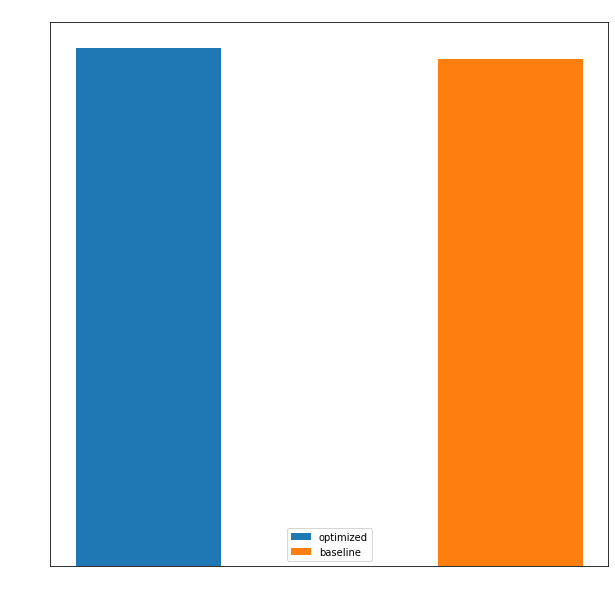

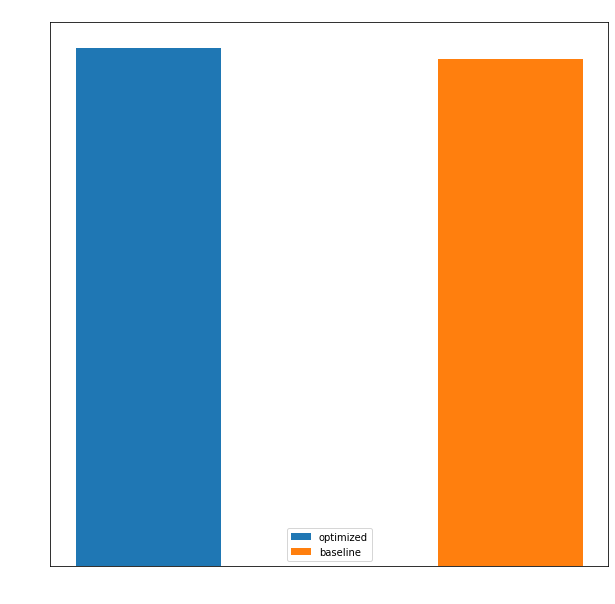

In [0]:
#Creating a barplot for the F1 micro averages
compare_bars(1, gau_nb_f1_micro_sel, 2, gau_nb_f1_micro, "f1 micro score with Geussian", "fa micro score", \
             [1, 2] ,['Gaussian optimzied', 'Gaussian'])

#Creating a barplot for the F1 macro averages
compare_bars(1, gau_nb_f1_macro_sel, 2, gau_nb_f1_macro, "f1 macro score with Geussian", "fa macro score", \
             [1, 2] ,['Gaussian optimzied', 'Gaussian'])

- Selector and normalization

In [0]:
steps=[('selector', selector),('scaler', scaler),('gnb', gnb)]
grid_params={'selector__threshold':vthreshold}

preds, ttime, best = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_micro')

gau_nb_f1_micro_sel_norm = f1_score(y_test, preds, average="micro")

preds, ttime, best = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_macro')

gau_nb_f1_macro_sel_norm = f1_score(y_test, preds, average="macro")

print("Gaussian NB with selector and normalization")
print("f1-micro average: %f" %gau_nb_f1_micro_sel_norm)
print("f1-macro average: %f" %gau_nb_f1_macro_sel_norm)
print(best)
print()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Gaussian NB with selector and normalization
f1-micro average: 0.073261
f1-macro average: 0.073084
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=10000000.0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gnb', GaussianNB(priors=None, var_smoothing=1e-09))],
         verbose=False)



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


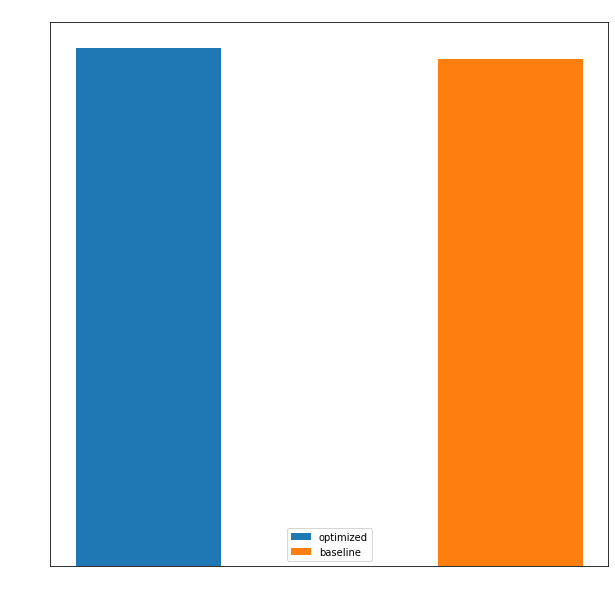

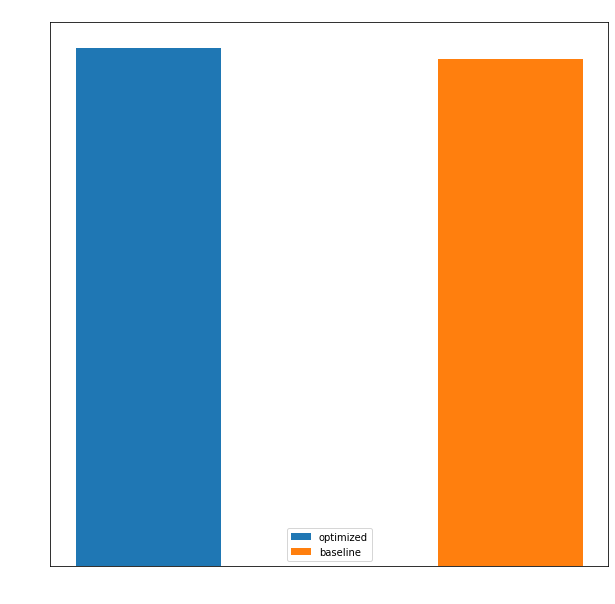

In [0]:
#Creating a barplot for the F1 micro averages
compare_bars(1, gau_nb_f1_micro_sel_norm, 2, gau_nb_f1_micro, "f1 micro score with Geussian", "fa micro score", \
             [1, 2] ,['Gaussian optimzied', 'Gaussian'])

#Creating a barplot for the F1 macro averages
compare_bars(1, gau_nb_f1_macro_sel_norm, 2, gau_nb_f1_macro, "f1 macro score with Geussian", "fa macro score", \
             [1, 2] ,['Gaussian optimzied', 'Gaussian'])


- Selector, normalization and oversampling

In [0]:
steps=[('selector', selector),('scaler', scaler),('ros',ros),('gnb', gnb)]
grid_params={'selector__threshold':vthreshold}

preds, ttime, best = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_micro')

gau_nb_f1_micro_sel_norm_ov = f1_score(y_test, preds, average="micro")

preds, ttime, best = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_macro')

gau_nb_f1_macro_sel_norm_ov = f1_score(y_test, preds, average="macro")

print("Gaussian NB with selector, normalization and oversampling")
print("f1-micro average: %f" %gau_nb_f1_micro_sel_norm_ov)
print("f1-macro average: %f" %gau_nb_f1_macro_sel_norm_ov)
print(best)
print()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Gaussian NB with selector, normalization and oversampling
f1-micro average: 0.070650
f1-macro average: 0.070394
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=10000000.0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ros',
                 RandomOverSampler(random_state=None, ratio=None,
                                   return_indices=False,
                                   sampling_strategy='auto')),
                ('gnb', GaussianNB(priors=None, var_smoothing=1e-09))],
         verbose=False)



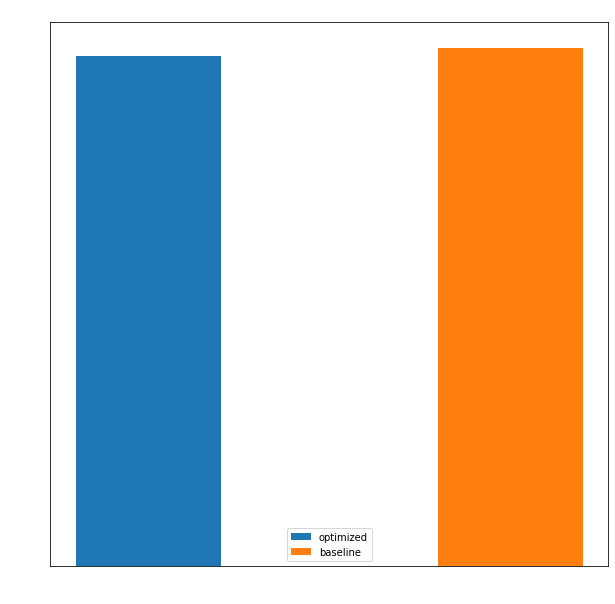

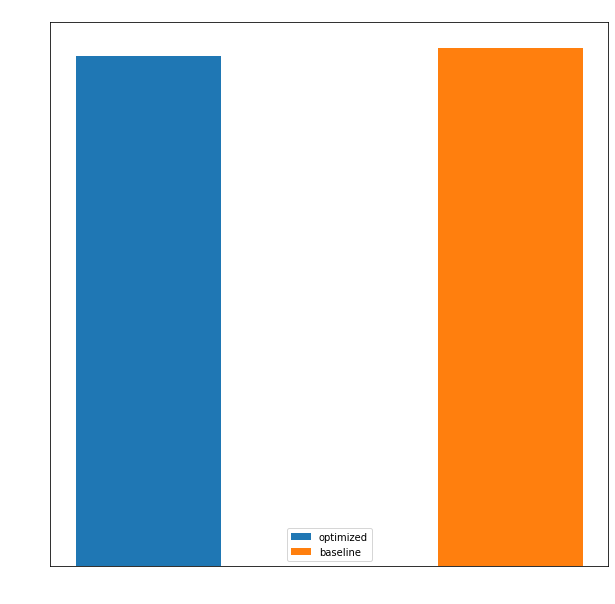

In [0]:
#Creating a barplot for the F1 micro averages
compare_bars(1, gau_nb_f1_micro_sel_norm_ov, 2, gau_nb_f1_micro, "f1 micro score with Geussian", "fa micro score", \
             [1, 2] ,['Gaussian optimzied', 'Gaussian'])

#Creating a barplot for the F1 macro averages
compare_bars(1, gau_nb_f1_macro_sel_norm_ov, 2, gau_nb_f1_macro, "f1 macro score with Geussian", "fa macro score", \
             [1, 2] ,['Gaussian optimzied', 'Gaussian'])


- Selector, normalization, oversampling and PCA

In [0]:
steps=[('selector', selector),('scaler', scaler),('ros',ros),('pca', pca), ('gnb', gnb)]
grid_params={'selector__threshold':vthreshold, 'pca__n_components':n_components}

preds, ttime, best = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_micro')

gau_nb_f1_micro_sel_norm_ov_pca = f1_score(y_test, preds, average="micro")

preds, ttime, best = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_macro')

gau_nb_f1_macro_sel_norm_ov_pca = f1_score(y_test, preds, average="macro")

print("Gaussian NB with selector and normalization")
print("f1-micro average: %f" %gau_nb_f1_micro_sel_norm_ov_pca)
print("f1-macro average: %f" %gau_nb_f1_macro_sel_norm_ov_pca)
print(best)
print()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Gaussian NB with selector and normalization
f1-micro average: 0.952772
f1-macro average: 0.489527
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0.0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ros',
                 RandomOverSampler(random_state=None, ratio=None,
                                   return_indices=False,
                                   sampling_strategy='auto')),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('gnb', GaussianNB(priors=None, var_smoothing=1e-09))],
         verbose=False)



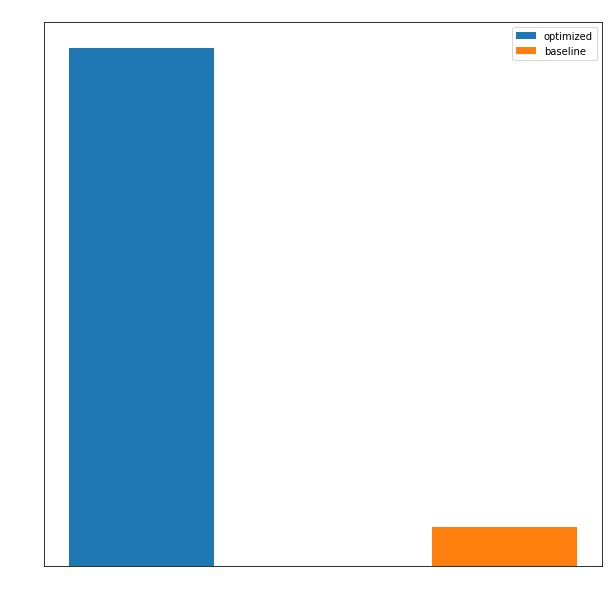

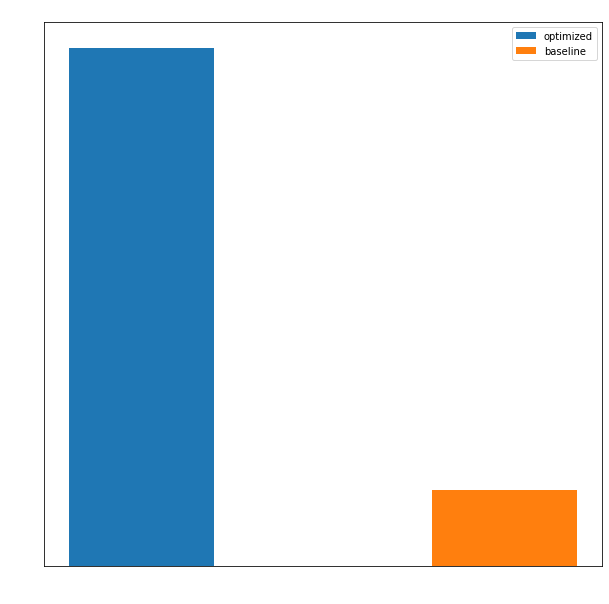

In [0]:
#Creating a barplot for the F1 micro averages
compare_bars(1, gau_nb_f1_micro_sel_norm_ov_pca, 2, gau_nb_f1_micro, "f1 micro score with Geussian", "fa micro score", \
             [1, 2] ,['Gaussian optimzied', 'Gaussian'])

#Creating a barplot for the F1 macro averages
compare_bars(1, gau_nb_f1_macro_sel_norm_ov_pca, 2, gau_nb_f1_macro, "f1 macro score with Geussian", "fa macro score", \
             [1, 2] ,['Gaussian optimzied', 'Gaussian'])

- Only oversampling and PCA

In [0]:
steps=[('ros',ros),('pca', pca), ('gnb', gnb)]
grid_params={'pca__n_components':n_components}

preds, ttime, best = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_micro')

gau_nb_f1_micro_ov_pca = f1_score(y_test, preds, average="micro")

preds, ttime, best = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_macro')

gau_nb_f1_macro_ov_pca = f1_score(y_test, preds, average="macro")

print("Gaussian NB with oversampling and pca")
print("f1-micro average: %f" %gau_nb_f1_micro_ov_pca)
print("f1-macro average: %f" %gau_nb_f1_macro_ov_pca)
print(best)
print()

Gaussian NB with oversampling and pca
f1-micro average: 0.079250
f1-macro average: 0.079198
Pipeline(memory='tmp',
         steps=[('ros',
                 RandomOverSampler(random_state=None, ratio=None,
                                   return_indices=False,
                                   sampling_strategy='auto')),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('gnb', GaussianNB(priors=None, var_smoothing=1e-09))],
         verbose=False)



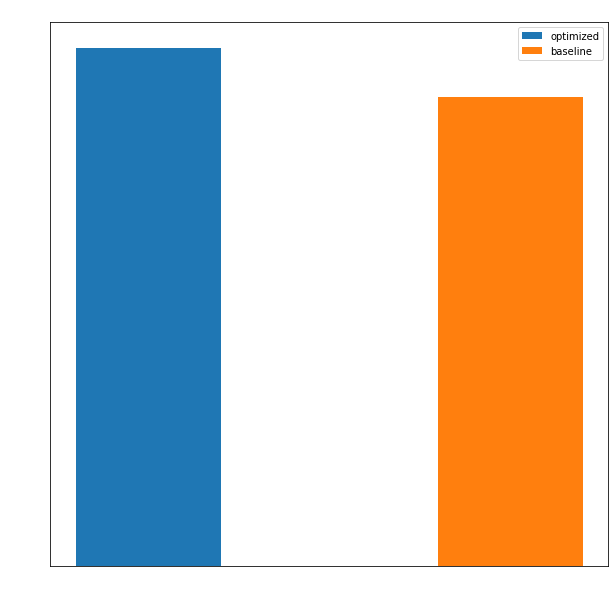

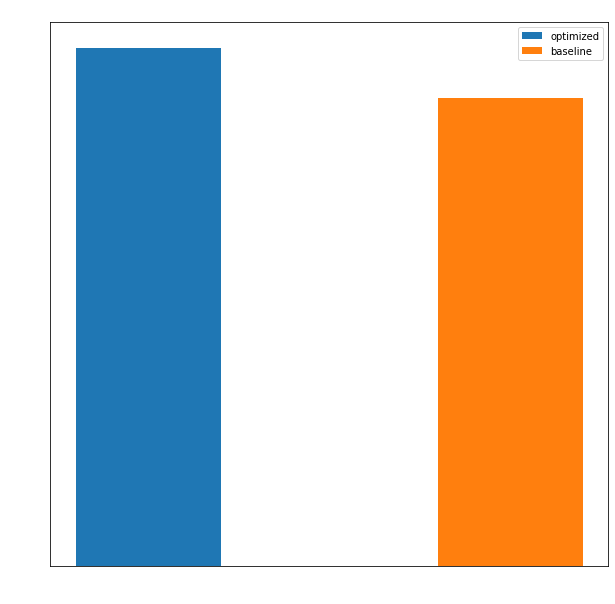

In [0]:
#Creating a barplot for the F1 micro averages
compare_bars(1, gau_nb_f1_micro_ov_pca, 2, gau_nb_f1_micro, "f1 micro score with Geussian", "fa micro score", \
             [1, 2] ,['Gaussian optimzied', 'Gaussian'])

#Creating a barplot for the F1 macro averages
compare_bars(1, gau_nb_f1_macro_ov_pca, 2, gau_nb_f1_macro, "f1 macro score with Geussian", "fa macro score", \
             [1, 2] ,['Gaussian optimzied', 'Gaussian'])

## k-NN classifier

Define a k-nn classifier without parameters.

In [0]:
neigh = KNeighborsClassifier()

Define hyperparameters for KNN.

In [0]:
k = [3, 5, 7]
weights = ['uniform','distance']
metric = ['euclidean','manhattan']

- k-nn without preprocessing

In [0]:
steps=[('neigh', neigh)]
grid_params={'neigh__n_neighbors':k, 'neigh__weights':weights, 'neigh__metric':metric}

preds_micro, ttime_micro, best_micro = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_micro')

preds_macro, ttime_macro, best_macro = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_macro')
 


/usr/local/lib/python3.6/dist-packages/imblearn/pipeline.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
/usr/local/lib/python3.6/dist-packages/imblearn/pipeline.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)


In [0]:
neigh_f1_micro_opt = f1_score(y_test, preds_micro, average="micro")
neigh_f1_macro_opt = f1_score(y_test, preds_macro, average="macro")

In [0]:
print("k-NN classifier without preprocessing")

print('F1 micro: %f' %neigh_f1_micro_opt)
print('Time of fit and predict: %f' %ttime_micro)
print('Best model in maximizing f1-micro')
print(best_micro)


print('F1 macro: %f' %neigh_f1_macro_opt)
print('Time of fit and predict: %f' %ttime_macro)
print('Best model in maximizing f1-macro')
print(best_macro)

k-NN classifier without preprocessing
F1 micro: 0.954999
Time of fit and predict: 138.336016
Best model in maximizing f1-micro
Pipeline(memory='tmp',
         steps=[('neigh',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='manhattan', metric_params=None,
                                      n_jobs=None, n_neighbors=7, p=2,
                                      weights='uniform'))],
         verbose=False)
F1 macro: 0.574917
Time of fit and predict: 137.976386
Best model in maximizing f1-macro
Pipeline(memory='tmp',
         steps=[('neigh',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='manhattan', metric_params=None,
                                      n_jobs=None, n_neighbors=3, p=2,
                                      weights='uniform'))],
         verbose=False)


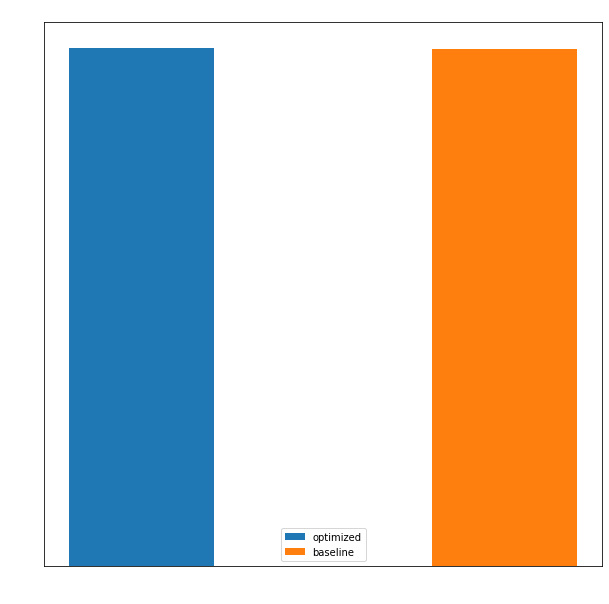

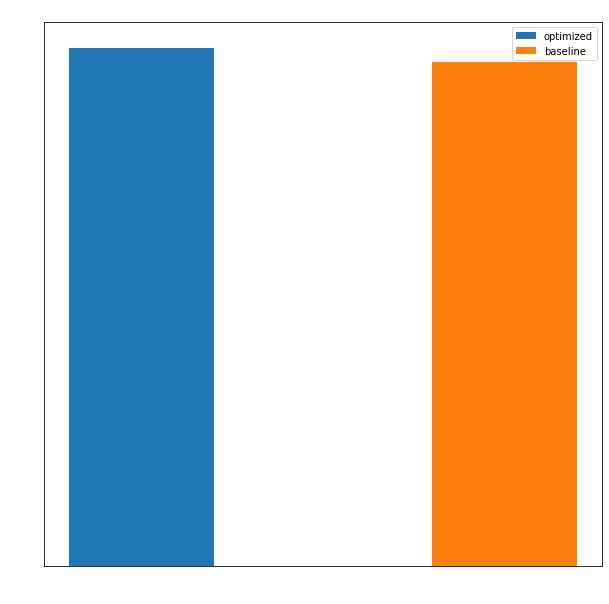

In [0]:
#Creating a barplot for the F1 micro averages
compare_bars(1, neigh_f1_micro_opt, 2, neigh_f1_micro, "f1 micro score with k-nn", "f1 micro score", \
             [1, 2] ,['k-nn optimzied', 'k-nn'])

#Creating a barplot for the F1 macro averages
compare_bars(1, neigh_f1_macro_opt, 2, neigh_f1_macro, "f1 macro score with k-nn", "f1 macro score", \
             [1, 2] ,['k-nn optimzied', 'k-nn'])

- Selector only

In [0]:
steps=[('selector', selector), ('neigh', neigh)]
grid_params={'selector__threshold':vthreshold, 'neigh__n_neighbors':k, 'neigh__weights':weights, 'neigh__metric':metric}

preds_micro, ttime_micro, best_micro = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_micro')

preds_macro, ttime_macro, best_macro = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_macro')


In [0]:
neigh_f1_micro_sel = f1_score(y_test, preds_micro, average="micro")
neigh_f1_macro_sel = f1_score(y_test, preds_macro, average="macro")

In [0]:
print("k-NN classifier using Variance Thresholder")

print('F1 micro: %f' %neigh_f1_micro_sel)
print('Time of fit and predict: %f' %ttime_micro)
print('Best model in maximizing f1-micro')
print(best_micro)


print('F1 macro: %f' %neigh_f1_macro_sel)
print('Time of fit and predict: %f' %ttime_macro)
print('Best model in maximizing f1-macro')
print(best_macro)

k-NN classifier using Variance Thresholder
F1 micro: 0.950468
Time of fit and predict: 325.870107
Best model in maximizing f1-micro
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=5000000.0)),
                ('neigh',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='manhattan', metric_params=None,
                                      n_jobs=None, n_neighbors=7, p=2,
                                      weights='uniform'))],
         verbose=False)
F1 macro: 0.505087
Time of fit and predict: 329.104980
Best model in maximizing f1-macro
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0.0)),
                ('neigh',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='manhattan', metric_params=None,
                                      n_jobs=None, n_neighbors=3, p=2,
                         

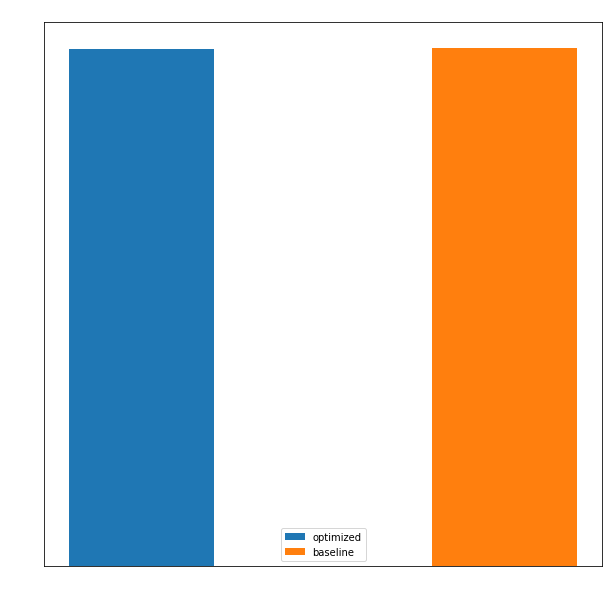

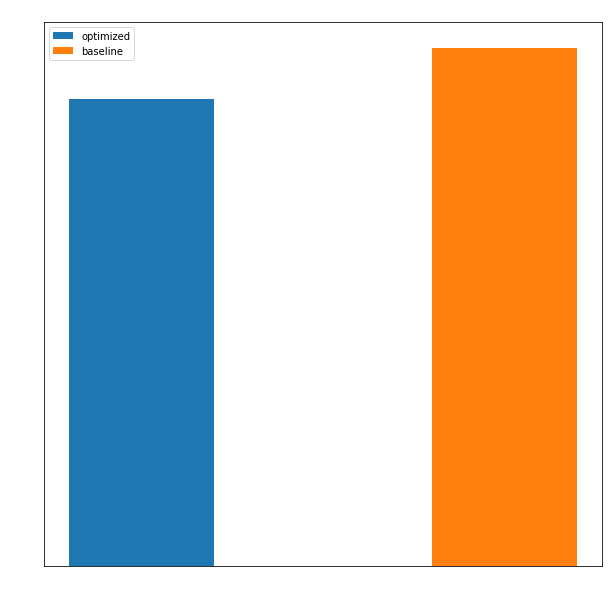

In [0]:
#Creating a barplot for the F1 micro averages
compare_bars(1, neigh_f1_micro_sel, 2, neigh_f1_micro, "f1 micro score with k-nn", "f1 micro score", \
             [1, 2] ,['k-nn optimzied', 'k-nn'])

#Creating a barplot for the F1 macro averages
compare_bars(1, neigh_f1_macro_sel, 2, neigh_f1_macro, "f1 macro score with k-nn", "f1 macro score", \
             [1, 2] ,['k-nn optimzied', 'k-nn'])

- Selector and scaler

In [0]:
steps=[('selector', selector), ('scaler', scaler), ('neigh', neigh)]
grid_params={'selector__threshold':vthreshold, 'neigh__n_neighbors':k, 'neigh__weights':weights, 'neigh__metric':metric}

preds_micro, ttime_micro, best_micro = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_micro')


preds_macro, ttime_macro, best_macro = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_macro')


In [0]:
neigh_f1_micro_sel_norm = f1_score(y_test, preds_micro, average="micro")
neigh_f1_macro_sel_norm = f1_score(y_test, preds_macro, average="macro")

In [0]:
print("k-NN classifier using Variance Thresholder and Normalization")

print('F1 micro: %f' %neigh_f1_micro_sel_norm)
print('Time of fit and predict: %f' %ttime_micro)
print('Best model in maximizing f1-micro')
print(best_micro)


print('F1 macro: %f' %neigh_f1_macro_sel_norm)
print('Time of fit and predict: %f' %ttime_macro)
print('Best model in maximizing f1-macro')
print(best_macro)

k-NN classifier using Variance Thresholder and Normalization
F1 micro: 0.947857
Time of fit and predict: 943.399189
Best model in maximizing f1-micro
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=10000000.0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('neigh',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='manhattan', metric_params=None,
                                      n_jobs=None, n_neighbors=7, p=2,
                                      weights='uniform'))],
         verbose=False)
F1 macro: 0.505802
Time of fit and predict: 949.282986
Best model in maximizing f1-macro
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=10000000.0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('neigh',
            

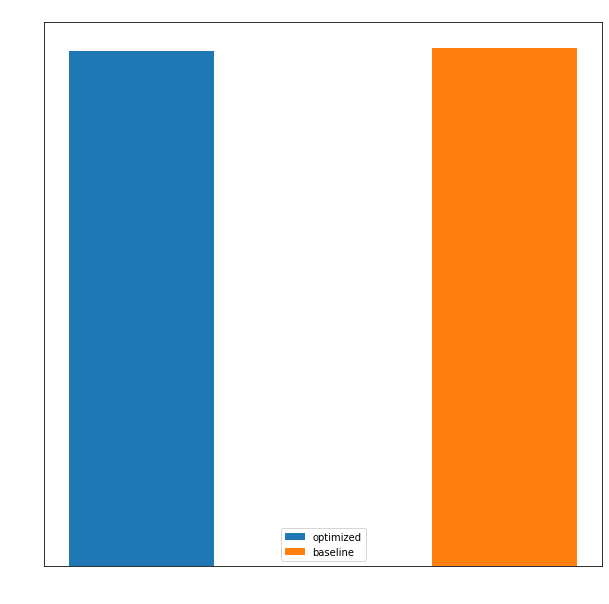

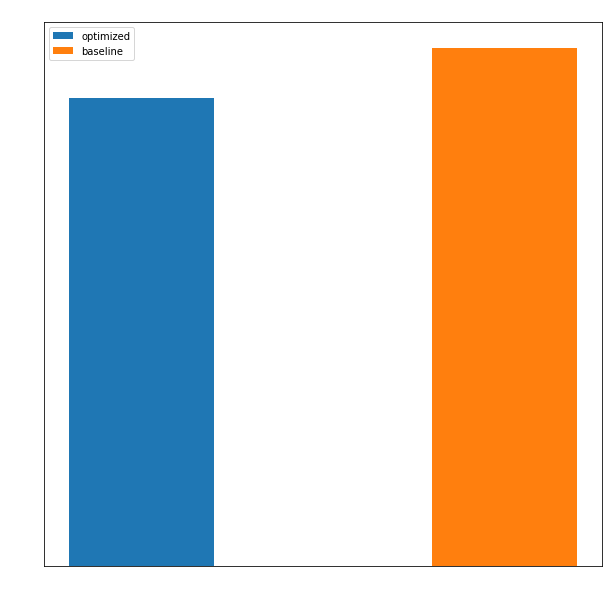

In [0]:
#Creating a barplot for the F1 micro averages
compare_bars(1, neigh_f1_micro_sel_norm, 2, neigh_f1_micro, "f1 micro score with k-nn", "f1 micro score", \
             [1, 2] ,['k-nn optimzied', 'k-nn'])

#Creating a barplot for the F1 macro averages
compare_bars(1, neigh_f1_macro_sel_norm, 2, neigh_f1_macro, "f1 macro score with k-nn", "f1 macro score", \
             [1, 2] ,['k-nn optimzied', 'k-nn'])

- Selector, normalization and oversampling

In [0]:
steps=[('selector', selector), ('scaler', scaler), ('ros', ros), ('neigh', neigh)]
grid_params={'selector__threshold':vthreshold, 'neigh__n_neighbors':k, 'neigh__weights':weights, 'neigh__metric':metric}

preds_micro, ttime_micro, best_micro = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_micro')


preds_macro, ttime_macro, best_macro = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_macro')


In [0]:
neigh_f1_micro_sel_norm_ros = f1_score(y_test, preds_micro, average="micro")
neigh_f1_macro_sel_norm_ros = f1_score(y_test, preds_macro, average="macro")

In [0]:
print("k-NN classifier using Variance Thresholder, Normalization and Oversampling")

print('F1 micro: %f' %neigh_f1_micro_sel_norm_ros)
print('Time of fit and predict: %f' %ttime_micro)
print('Best model in maximizing f1-micro')
print(best_micro)


print('F1 macro: %f' %neigh_f1_macro_sel_norm_ros)
print('Time of fit and predict: %f' %ttime_macro)
print('Best model in maximizing f1-macro')
print(best_macro)

k-NN classifier using Variance Thresholder, Normalization and Oversampling
F1 micro: 0.883351
Time of fit and predict: 1355.501502
Best model in maximizing f1-micro
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0.0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ros',
                 RandomOverSampler(random_state=None, ratio=None,
                                   return_indices=False,
                                   sampling_strategy='auto')),
                ('neigh',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='manhattan', metric_params=None,
                                      n_jobs=None, n_neighbors=3, p=2,
                                      weights='uniform'))],
         verbose=False)
F1 macro: 0.498631
Time of fit and predict: 1222.349464
Best model in maximizing f1-macro
Pipeline(memory=

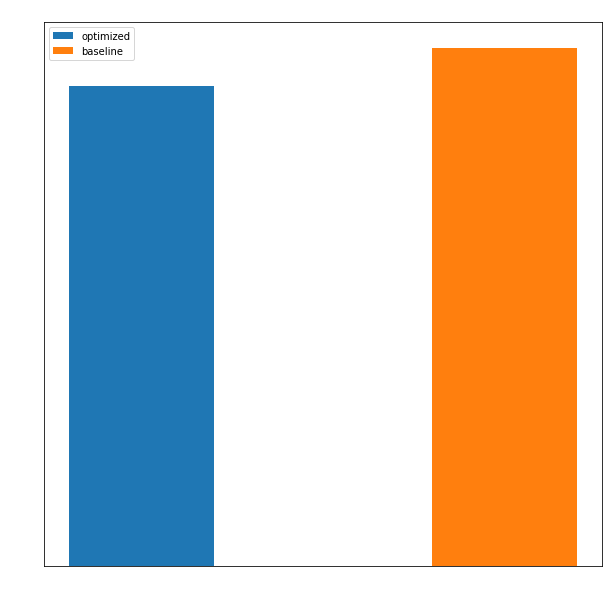

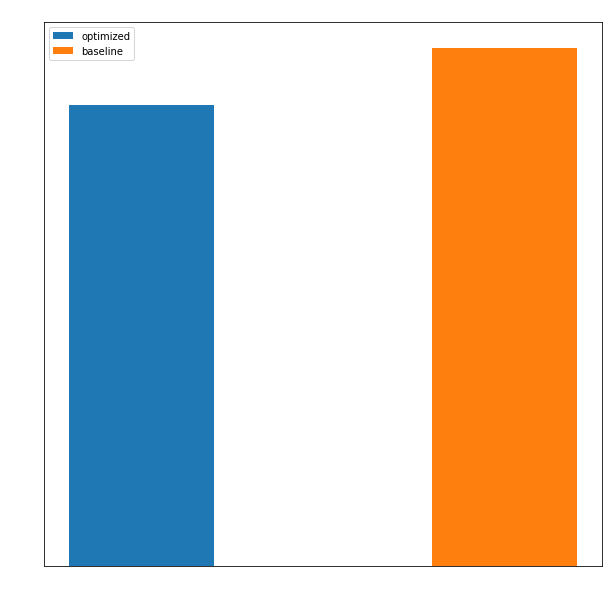

In [0]:
#Creating a barplot for the F1 micro averages
compare_bars(1, neigh_f1_micro_sel_norm_ros, 2, neigh_f1_micro, "f1 micro score with k-nn", "f1 micro score", \
             [1, 2] ,['k-nn optimzied', 'k-nn'])

#Creating a barplot for the F1 macro averages
compare_bars(1, neigh_f1_macro_sel_norm_ros, 2, neigh_f1_macro, "f1 macro score with k-nn", "f1 macro score", \
             [1, 2] ,['k-nn optimzied', 'k-nn'])

- Selection, normalization, oversamping and PCA

In [0]:
steps=[('selector', selector), ('scaler', scaler), ('ros', ros), ('pca', pca), ('neigh', neigh)]
grid_params={'selector__threshold':vthreshold, 'neigh__n_neighbors':k, 'neigh__weights':weights, 'neigh__metric':metric}

preds_micro, ttime_micro, best_micro = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_micro')


preds_macro, ttime_macro, best_macro = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_macro')


In [0]:
neigh_f1_micro_sel_norm_ros_pca = f1_score(y_test, preds_micro, average="micro")
neigh_f1_macro_sel_norm_ros_pca = f1_score(y_test, preds_macro, average="macro")

In [0]:
print("k-NN classifier using Variance Thresholder, Normalization, Oversampling and PCA")

print('F1 micro: %f' %neigh_f1_micro_sel_norm_ros_pca)
print('Time of fit and predict: %f' %ttime_micro)
print('Best model in maximizing f1-micro')
print(best_micro)


print('F1 macro: %f' %neigh_f1_macro_sel_norm_ros_pca)
print('Time of fit and predict: %f' %ttime_macro)
print('Best model in maximizing f1-macro')
print(best_macro)

k-NN classifier using Variance Thresholder, Normalization, Oversampling and PCA
F1 micro: 0.887805
Time of fit and predict: 980.935765
Best model in maximizing f1-micro
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0.0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ros',
                 RandomOverSampler(random_state=None, ratio=None,
                                   return_indices=False,
                                   sampling_strategy='auto')),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('neigh',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='manhattan', metric_params=None,
                                      n_jobs=None, n_n

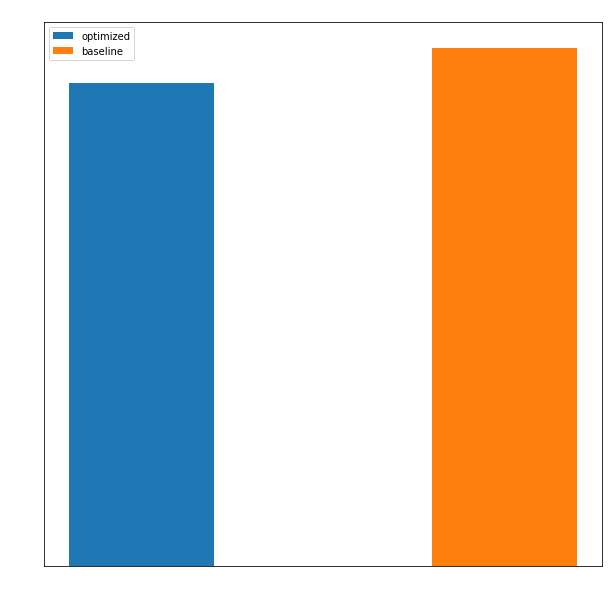

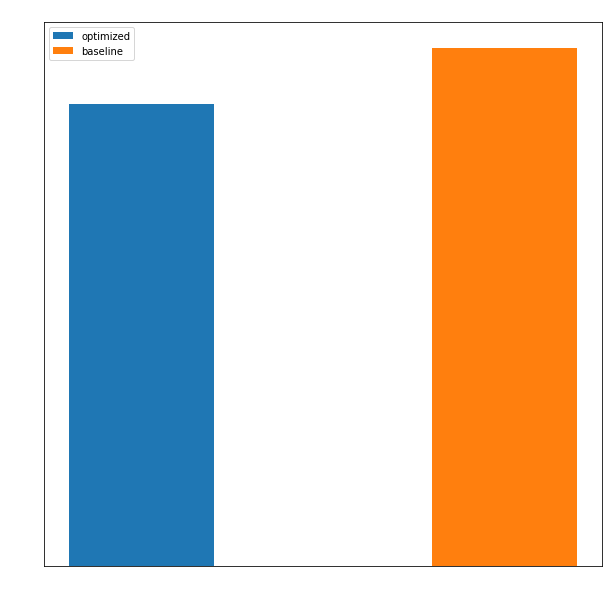

In [0]:
#Creating a barplot for the F1 micro averages
compare_bars(1, neigh_f1_micro_sel_norm_ros_pca, 2, neigh_f1_micro, "f1 micro score with k-nn", "f1 micro score", \
             [1, 2] ,[' k-nn optimzied', 'k-nn'])

#Creating a barplot for the F1 macro averages
compare_bars(1, neigh_f1_macro_sel_norm_ros_pca, 2, neigh_f1_macro, "f1 macro score with k-nn", "f1 macro score", \
             [1, 2] ,['k-nn optimzied', 'k-nn'])

## MLP classifier

- Define a Multi-layer Perceptron classifier without any parameter.

In [0]:
mlp =  MLPClassifier()

- Define the possible hyperparameters for Grid Search.

In [0]:
hidden_layer_sizes = [4, 8]
activations = ['logistic', 'tanh', 'relu']
solvers = ['lbfgs', 'sgd', 'adam']
max_iters = [50, 100]
learning_rates = ['constant', 'invscaling', 'adaptive']
alphas = [0.001, 0.0001]

**1. MLP without preprocessing**

In [0]:
steps=[('mlp', mlp)]
grid_params = {}
grid_params['mlp__hidden_layer_sizes'] = hidden_layer_sizes
grid_params['mlp__activation'] = activations
grid_params['mlp__solver'] = solvers
grid_params['mlp__max_iter'] = max_iters
grid_params['mlp__learning_rate'] = learning_rates
grid_params['mlp__alpha'] = alphas

preds_micro, ttime_micro, best_micro = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_micro')

preds_macro, ttime_macro, best_macro = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_macro')



In [0]:
mlp_f1_micro_opt = f1_score(y_test, preds_micro, average="micro")
mlp_f1_macro_opt = f1_score(y_test, preds_macro, average="macro")

In [0]:
print("MLP classifier without preprocessing")

print('F1 micro: %f' %mlp_f1_micro_opt)
print('Time of fit and predict: %f' %ttime_micro)
print('Best model in maximizing f1-micro')
print(best_micro)


print('F1 macro: %f' %mlp_f1_macro_opt)
print('Time of fit and predict: %f' %ttime_macro)
print('Best model in maximizing f1-macro')
print(best_macro)

MLP classifier without preprocessing
F1 micro: 0.955306
Time of fit and predict: 1976.779135
Best model in maximizing f1-micro
Pipeline(memory='tmp',
         steps=[('mlp',
                 MLPClassifier(activation='logistic', alpha=0.001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=8, learning_rate='adaptive',
                               learning_rate_init=0.001, max_iter=100,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=None, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)
F1 macro: 0.494373
Time of fit and predict: 1994.264817
Best model in maximizing f1-macro
Pi

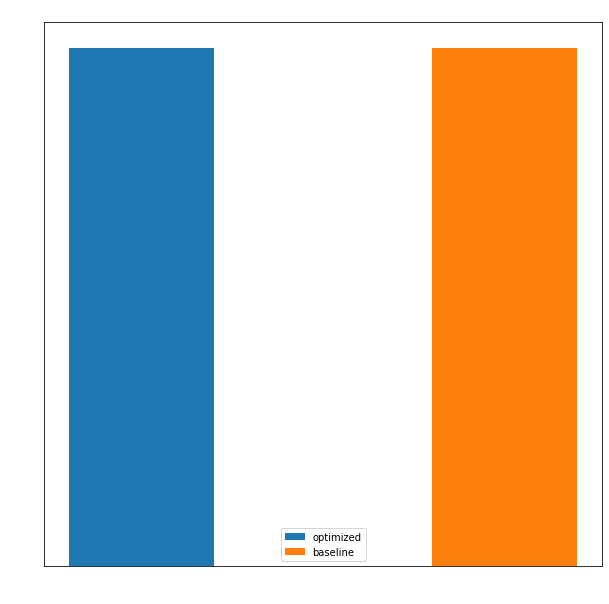

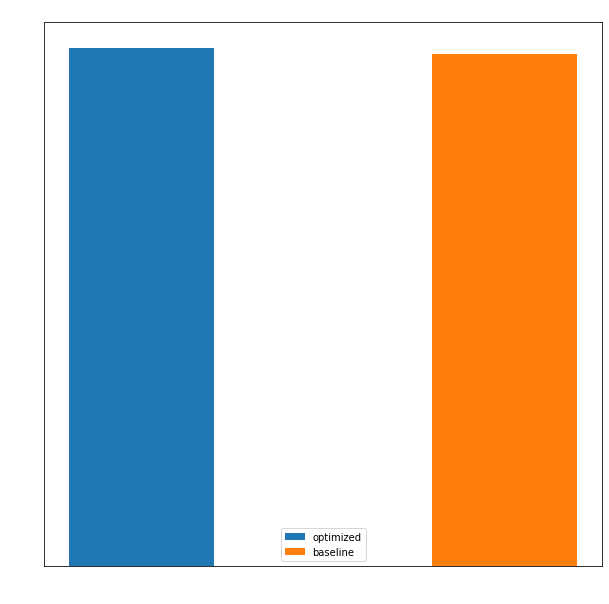

In [0]:
#Creating a barplot for the F1 micro averages
compare_bars(1, mlp_f1_micro_opt, 2, mlp_f1_micro, "f1 micro score with MLP", "f1 micro score", \
             [1, 2] ,['MLP optimzied', 'MLP'])

#Creating a barplot for the F1 macro averages
compare_bars(1, mlp_f1_macro_opt, 2, mlp_f1_macro, "f1 macro score with MLP", "f1 macro score", \
             [1, 2] ,['MLP optimzied', 'MLP'])

**2. Feature Selector + MLP**

In [0]:
steps = [('selector', selector), ('mlp', mlp)]
grid_params = {}
grid_params['selector__threshold'] = vthreshold
grid_params['mlp__hidden_layer_sizes'] = hidden_layer_sizes
grid_params['mlp__activation'] = activations
grid_params['mlp__solver'] = solvers
grid_params['mlp__max_iter'] = max_iters
grid_params['mlp__learning_rate'] = learning_rates
grid_params['mlp__alpha'] = alphas

preds_micro, ttime_micro, best_micro = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_micro')

preds_macro, ttime_macro, best_macro = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_macro')


In [0]:
mlp_f1_micro_opt_sel = f1_score(y_test, preds_micro, average="micro")
mlp_f1_macro_opt_sel = f1_score(y_test, preds_macro, average="macro")

In [0]:
print("MLP classifier using Variance Thresholder")

print('F1 micro: %f' %mlp_f1_micro_opt_sel)
print('Time of fit and predict: %f' %ttime_micro)
print('Best model in maximizing f1-micro')
print(best_micro)


print('F1 macro: %f' %mlp_f1_macro_opt_sel)
print('Time of fit and predict: %f' %ttime_macro)
print('Best model in maximizing f1-macro')
print(best_macro)

MLP classifier using Variance Thresholder
F1 micro: 0.944402
Time of fit and predict: 1253.768752
Best model in maximizing f1-micro
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=10000000.0)),
                ('mlp',
                 MLPClassifier(activation='tanh', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=8, learning_rate='adaptive',
                               learning_rate_init=0.001, max_iter=100,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=None, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=None)
F1 macro: 0.499965
T

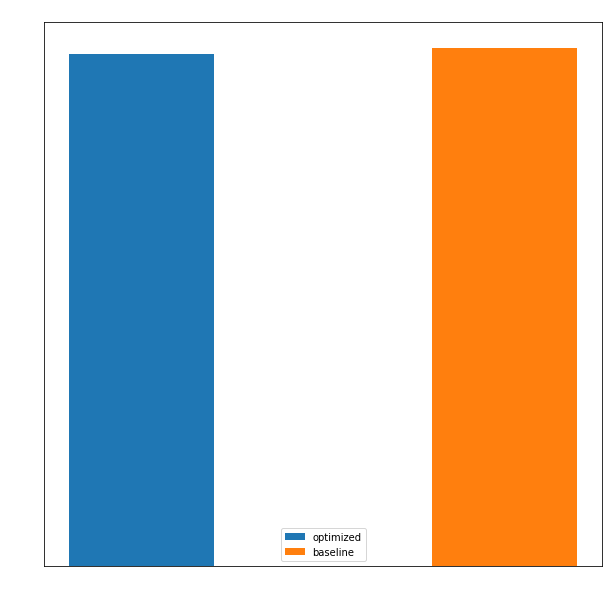

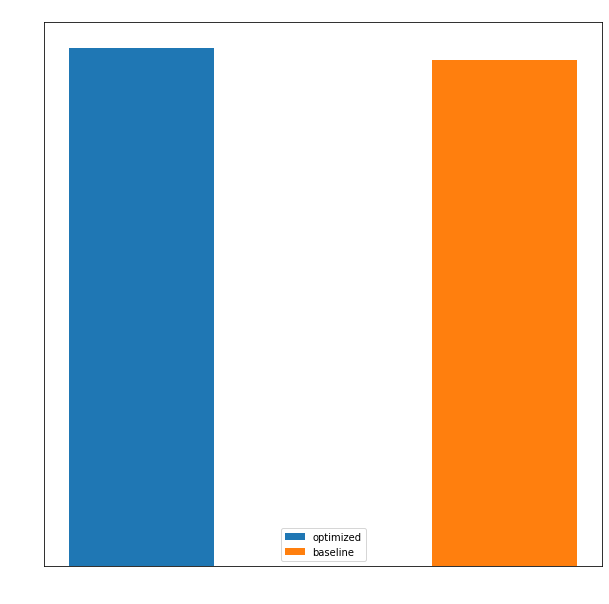

In [0]:
#Creating a barplot for the F1 micro averages
compare_bars(1, mlp_f1_micro_opt_sel, 2, mlp_f1_micro, "f1 micro score with MLP", "f1 micro score", \
             [1, 2] ,['MLP optimzied', 'MLP'])

#Creating a barplot for the F1 macro averages
compare_bars(1, mlp_f1_macro_opt_sel, 2, mlp_f1_macro, "f1 macro score with MLP", "f1 macro score", \
             [1, 2] ,['MLP optimzied', 'MLP'])

**3. Feature selector + Scaler + MLP**

In [0]:
steps= [('selector', selector), ('scaler', scaler),  ('mlp', mlp)]

preds_micro, ttime_micro, best_micro = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_micro')

preds_macro, ttime_macro, best_macro = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_macro')


In [0]:
mlp_f1_micro_opt_sel_sc = f1_score(y_test, preds_micro, average="micro")
mlp_f1_macro_opt_sel_sc = f1_score(y_test, preds_macro, average="macro")

In [0]:
print("MLP classifier using Variance Thresholder and Normalization")

print('F1 micro: %f' %mlp_f1_micro_opt_sel_sc)
print('Time of fit and predict: %f' %ttime_micro)
print('Best model in maximizing f1-micro')
print(best_micro)


print('F1 macro: %f' %mlp_f1_macro_opt_sel_sc)
print('Time of fit and predict: %f' %ttime_macro)
print('Best model in maximizing f1-macro')
print(best_macro)

MLP classifier using Variance Thresholder and Normalization
F1 micro: 0.949854
Time of fit and predict: 1311.989875
Best model in maximizing f1-micro
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0.0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('mlp',
                 MLPClassifier(activation='tanh', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=8, learning_rate='adaptive',
                               learning_rate_init=0.001, max_iter=100,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=None, shuffle=True, solver='lbfgs',
                               tol=0.0001, validation_fraction=

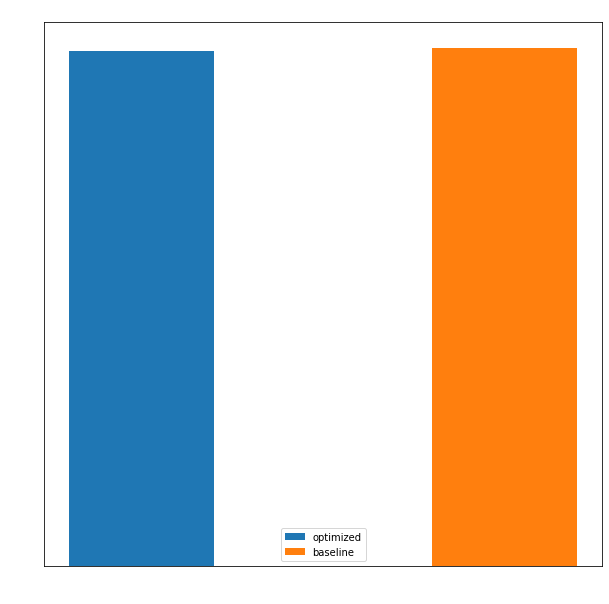

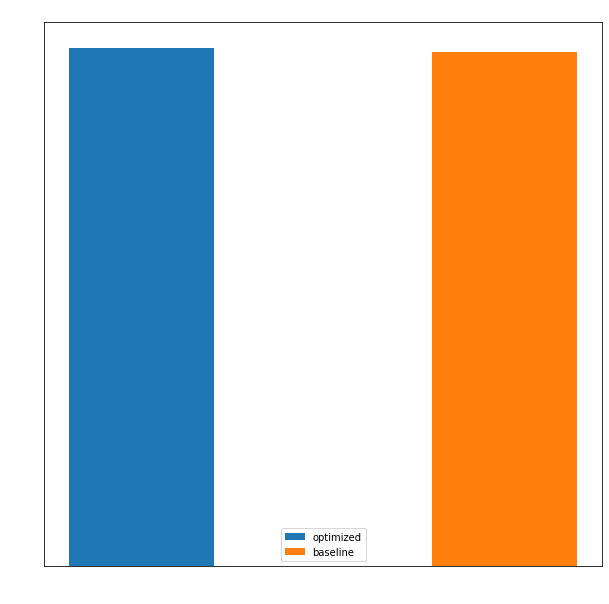

In [0]:
#Creating a barplot for the F1 micro averages
compare_bars(1, mlp_f1_micro_opt_sel_sc, 2, mlp_f1_micro, "f1 micro score with MLP", "f1 micro score", \
             [1, 2] ,['MLP optimzied', 'MLP'])

#Creating a barplot for the F1 macro averages
compare_bars(1, mlp_f1_macro_opt_sel_sc, 2, mlp_f1_macro, "f1 macro score with MLP", "f1 macro score", \
             [1, 2] ,['MLP optimzied', 'MLP'])

**4. Feature selector + Scaler + Oversampling + MLP**

In [0]:
steps= [('selector', selector), ('scaler', scaler), ('ros', ros),  ('mlp', mlp)]

preds_micro, ttime_micro, best_micro = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_micro')

preds_macro, ttime_macro, best_macro = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_macro')


In [0]:
mlp_f1_micro_opt_sel_sc_ros = f1_score(y_test, preds_micro, average="micro")
mlp_f1_macro_opt_sel_sc_ros = f1_score(y_test, preds_macro, average="macro")

In [0]:
print("MLP classifier using Variance Thresholder, Normalization and Oversampling")

print('F1 micro: %f' %mlp_f1_micro_opt_sel_sc_ros)
print('Time of fit and predict: %f' %ttime_micro)
print('Best model in maximizing f1-micro')
print(best_micro)


print('F1 macro: %f' %mlp_f1_macro_opt_sel_sc_ros)
print('Time of fit and predict: %f' %ttime_macro)
print('Best model in maximizing f1-macro')
print(best_macro)

MLP classifier using Variance Thresholder, Normalization and Oversampling
F1 micro: 0.048226
Time of fit and predict: 11183.376397
Best model in maximizing f1-micro
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0.0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ros',
                 RandomOverSampler(random_state=None, ratio=None,
                                   return_indices=False,
                                   sampling_strategy='auto')),
                ('mlp',
                 MLPClassifier(activation='logistic', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=4, learning_rate='invscaling',
                               learning_rate_init=0.001, max_iter=50,
                               momentum=0.9, n_i

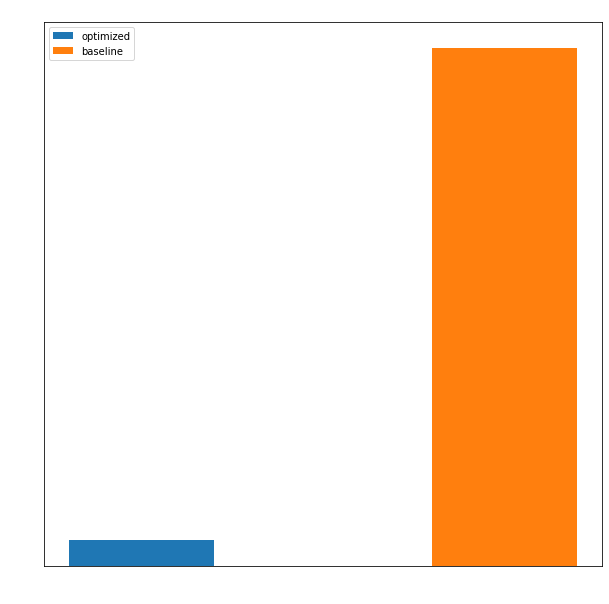

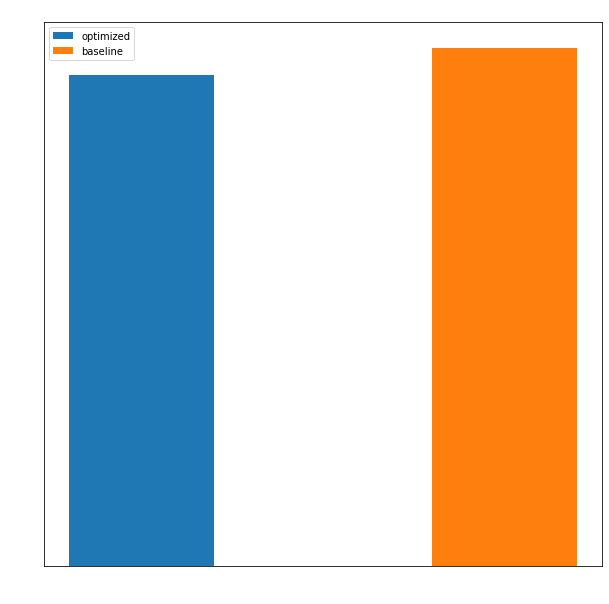

In [0]:
#Creating a barplot for the F1 micro averages
compare_bars(1, mlp_f1_micro_opt_sel_sc_ros, 2, mlp_f1_micro, "f1 micro score with MLP", "f1 micro score", \
             [1, 2] ,['MLP optimzied', 'MLP'])

#Creating a barplot for the F1 macro averages
compare_bars(1, mlp_f1_macro_opt_sel_sc_ros, 2, mlp_f1_macro, "f1 macro score with MLP", "f1 macro score", \
             [1, 2] ,['MLP optimzied', 'MLP'])

**5. Feature selector + Scaler + PCA + MLP**

In [0]:
steps= [('selector', selector), ('scaler', scaler), ('ros', ros), ('pca', pca), ('mlp', mlp)]

grid_params['pca__n_components'] = n_components

preds_micro, ttime_micro, best_micro = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_micro')

preds_macro, ttime_macro, best_macro = grid_eval(X_train, X_test, y_train, y_test, steps, grid_params, 'f1_macro')


In [0]:
mlp_f1_micro_opt_sel_sc_ros_pca = f1_score(y_test, preds_micro, average="micro")
mlp_f1_macro_opt_sel_sc_ros_pca = f1_score(y_test, preds_macro, average="macro") 

In [0]:
print("MLP classifier using Variance Thresholder, Normalization, Oversampling and PCA")

print('F1 micro: %f' %mlp_f1_micro_opt_sel_sc_ros_pca)
print('Time of fit and predict: %f' %ttime_micro)
print('Best model in maximizing f1-micro')
print(best_micro)


print('F1 macro: %f' %mlp_f1_macro_opt_sel_sc_ros_pca)
print('Time of fit and predict: %f' %ttime_macro)
print('Best model in maximizing f1-macro')
print(best_macro)

MLP classifier using Variance Thresholder, Normalization, Oversampling and PCA
F1 micro: 0.954922
Time of fit and predict: 5961.056648
Best model in maximizing f1-micro
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=5000000.0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ros',
                 RandomOverSampler(random_state=None, ratio=None,
                                   return_indices=False,
                                   sampling_strategy='auto')),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=7,
                     random_state=None, svd_solver='auto', tol=0.0...
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=4, learning_rate='invscaling',
                               lear

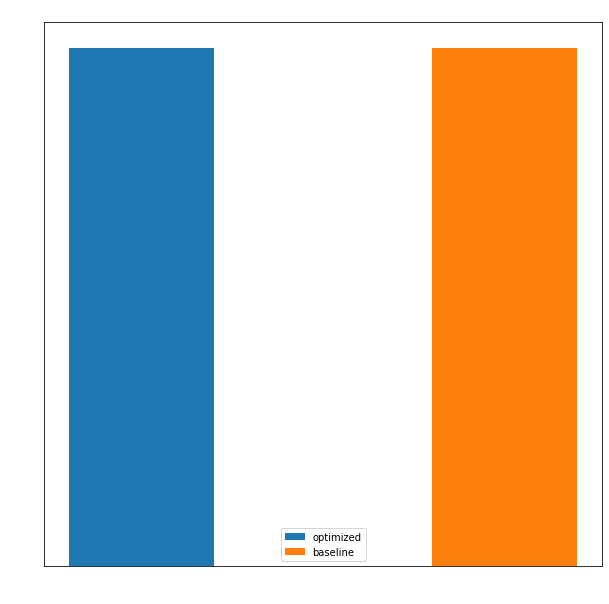

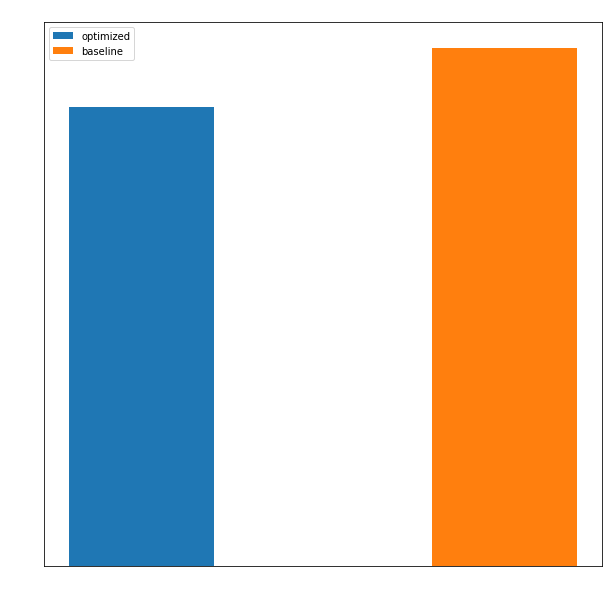

In [0]:
#Creating a barplot for the F1 micro averages
compare_bars(1, mlp_f1_micro_opt_sel_sc_ros_pca, 2, mlp_f1_micro, "f1 micro score with MLP", "f1 micro score", \
             [1, 2] ,['MLP optimzied', 'MLP'])

#Creating a barplot for the F1 macro averages
compare_bars(1, mlp_f1_macro_opt_sel_sc_ros_pca, 2, mlp_f1_macro, "f1 macro score with MLP", "f1 macro score", \
             [1, 2] ,['MLP optimzied', 'MLP'])

# Optimal Models

## Gaussian Naive Bayes classifier

### F1 - micro

In [0]:
steps=[('selector', VarianceThreshold(threshold=0)),('scaler', scaler),('ros',ros),('pca', PCA(n_components=5)), ('gnb', gnb)]
pipe = Pipeline(steps , memory = 'tmp')
pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)

gnb_mic_test = f1_score(y_test, preds, average="micro")

print("Metrics in test set")
print('Accuracy: %f' %pipe.score(X_test, y_test))
print('F1-micro: %f' %f1_score(y_test, preds, average="micro"))
print('F1-macro: %f' %f1_score(y_test, preds, average="macro"))

Metrics in test set
Accuracy: 0.952081
F1-micro: 0.952081
F1-macro: 0.503244


### F1 - macro

In [0]:
steps=[('selector', VarianceThreshold(threshold=0)),('scaler', scaler),('ros',ros),('pca', PCA(n_components=5)), ('gnb', gnb)]
pipe = Pipeline(steps , memory = 'tmp')
pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)

gnb_mac_test = f1_score(y_test, preds, average="macro")

print("Metrics in test set")
print('Accuracy: %f' %pipe.score(X_test, y_test))
print('F1-micro: %f' %f1_score(y_test, preds, average="micro"))
print('F1-macro: %f' %f1_score(y_test, preds, average="macro"))

Metrics in test set
Accuracy: 0.952081
F1-micro: 0.952081
F1-macro: 0.503244


## k-NN classifier

### F1 - micro

In [0]:
steps=[('neigh', KNeighborsClassifier(n_neighbors=7, weights='uniform', metric='manhattan'))]
pipe = Pipeline(steps , memory = 'tmp')
pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)

knn_mic_test = f1_score(y_test, preds, average="micro")

print("Metrics in test set")
print('Accuracy: %f' %pipe.score(X_test, y_test))
print('F1-micro: %f' %f1_score(y_test, preds, average="micro"))
print('F1-macro: %f' %f1_score(y_test, preds, average="macro"))

Metrics in test set
Accuracy: 0.955537
F1-micro: 0.955537
F1-macro: 0.555856


### F1 - macro

In [0]:
steps=[('neigh', KNeighborsClassifier(n_neighbors=7, weights='uniform', metric='manhattan'))]
pipe = Pipeline(steps , memory = 'tmp')
pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)

knn_mac_test = f1_score(y_test, preds, average="macro")

print("Metrics in test set")
print('Accuracy: %f' %pipe.score(X_test, y_test))
print('F1-micro: %f' %f1_score(y_test, preds, average="micro"))
print('F1-macro: %f' %f1_score(y_test, preds, average="macro"))

Metrics in test set
Accuracy: 0.955537
F1-micro: 0.955537
F1-macro: 0.555856


## MLP classifier

### F1 - micro

In [0]:
steps=[('mlp', MLPClassifier(hidden_layer_sizes=8, activation='logistic', solver='adam', alpha=0.001, learning_rate='adaptive', max_iter=100 ))]
pipe = Pipeline(steps , memory = 'tmp')
pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)

mlp_mic_test = f1_score(y_test, preds, average="micro")

print("Metrics in test set")
print('Accuracy: %f' %pipe.score(X_test, y_test))
print('F1-micro: %f' %f1_score(y_test, preds, average="micro"))
print('F1-macro: %f' %f1_score(y_test, preds, average="macro"))

Metrics in test set
Accuracy: 0.955614
F1-micro: 0.955614
F1-macro: 0.506975


### F1 - macro

In [0]:
steps=[('threshold', VarianceThreshold(0)), ('mlp', MLPClassifier(hidden_layer_sizes=8, activation='logistic', solver='adam', alpha=0.001, learning_rate='adaptive', max_iter=100 ))]
pipe = Pipeline(steps , memory = 'tmp')
pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)

mlp_mac_test = f1_score(y_test, preds, average="macro")

print("Metrics in test set")
print('Accuracy: %f' %pipe.score(X_test, y_test))
print('F1-micro: %f' %f1_score(y_test, preds, average="micro"))
print('F1-macro: %f' %f1_score(y_test, preds, average="macro"))

Metrics in test set
Accuracy: 0.954999
F1-micro: 0.954999
F1-macro: 0.488491


### Barplot

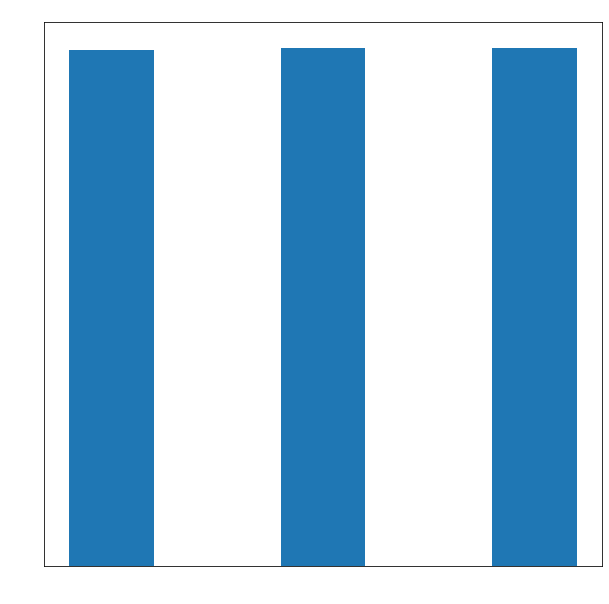

In [0]:
bars = plt.bar([1, 2, 3], [gnb_mic_test, knn_mic_test, mlp_mic_test], width=0.4)
plt.title("Optimized classifiers in F1-micro")
plt.ylabel('F1-micro' , color='w')
plt.xlabel("Strategy", color='w')
plt.xticks([1, 2, 3], ['Gaussian', 'k-NN', 'MLP'])

plt.show()

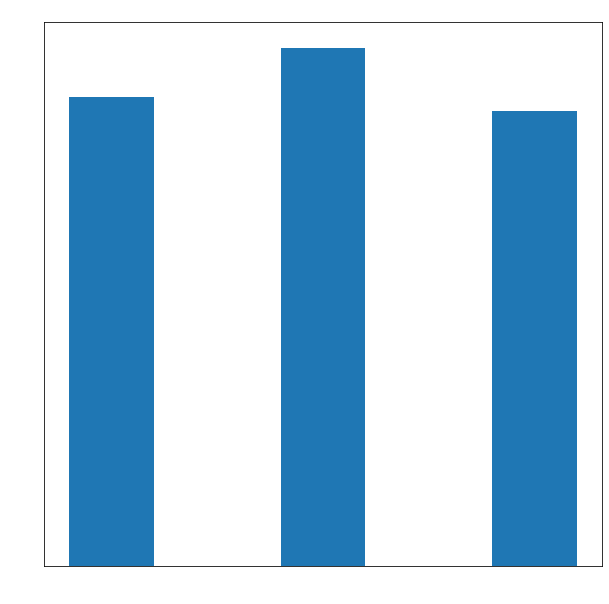

In [0]:
bars = plt.bar([1, 2, 3], [gnb_mac_test, knn_mac_test, mlp_mac_test], width=0.4)
plt.title("Optimized classifiers in F1-macro")
plt.ylabel('F1-macro' , color='w')
plt.xlabel("Strategy", color='w')
plt.xticks([1, 2, 3], ['Gaussian', 'k-NN', 'MLP'])

plt.show()

## Project questions

1. See the subsections of [Dummy classifiers](#scrollTo=BItGO00xGXtM),[Gaussian](#scrollTo=pxbmm48PT6ni), [k Nearest Neighbors](##scrollTo=0myqUAVjVpPR) and [MLP](#scrollTo=tApSKMjgVsy1).

2. See [Optimal Models](#scrollTo=p1w7J_KPa_kw).

3. See [Barplots](#scrollTo=Sr3iCkHhjUSG).


4.

|              Model             | Baseline f1 micro score | Optimized f1 micro score | Baseline f1 macro score | Optimized f1 macro score |
|:------------------------------:|:-----------------------:|:------------------------:|:-----------------------:|:------------------------:|
|    Uniform dummy classifier    |         0.499770        |         0.498848         |         0.369006        |         0.372135         |
|   Constant 0 dummy classifier  |         0.955306        |         0.954999         |         0.488571        |         0.488491         |
|   Constant 1 dummy classifier  |         0.044694        |         0.045001         |         0.042782        |         0.043063         |
| Most frequent dummy classifier |         0.955306        |         0.954999         |         0.488571        |         0.488491         |
|   Stratified dummy classifier  |         0.911381        |         0.500538         |         0.506879        |         0.371303         |
|     Gaussian   |        0.072        |         0.95        |         0.075        |         0.50        |
|   k-NN  |         0.94        |         0.96        |         0.55        |         0.56         |
|   MLP  |         0.95       |         0.95         |         0.48       |         0.49         |






5. As we can see in the table above, the most improved performance by the optimization is that of the kNN classifiers. Both kNN optimized for micro f1 score and kNN optimized for macro f1 score perform very well (in comparison with the baseline classification) on our test set. Thy hyperparameters we set (weights and distance) helped the model to improve its metrics.

  In general, f1-macro is very low because of the imbalance of the dataset. Even by using overampling, we did not manage to improve f1-macro a lot. This happened because we want more diverse data from companies that bankrupted (class 1).

  As for the MLP classifiers, they did not manage to achieve higher metrics than the k-nn. This might be due to the fact that they have a lot of hyperparameters and we may not tune them well.

  The Gaussian classifier without preprocessing is the worst classifier, because of its assumption that the features are normally distributed. However, after applying both the 4 preprocessing steps, Gaussian is as good as the other classifiers.

  Finally, the most valuable preprocessing step was the variance thresholder with small variance. Other steps such as PCA and normalization did not increase the metrics of the models (in general they help the model train faster).